1.1 Overview of the Codebase

Your codebase is structured into several modules, each handling different aspects of SHAP value computation, visualization, feedback generation, and data handling. Here's a brief summary:

    shap_calculator.py: Computes SHAP values for the dataset and individual trials.
    shap_visualizer.py: Generates SHAP plots (summary, dependence, and force plots).
    feedback_generator.py: Generates global and individual feedback based on SHAP values.
    shap_data_handler.py: Handles saving and loading SHAP values.
    predict_with_shap_usage.py: Orchestrates the entire pipeline: preprocessing, prediction, SHAP computation, visualization, and feedback generation.

1.2 Understanding the Flow

    Data Preprocessing:
        The DataPreprocessor filters and transforms input data.
        The preprocessed data (X_preprocessed) and the inversed data (X_inversed) are prepared for prediction and SHAP analysis.

    Model Prediction:
        The best model (e.g., CatBoost) is loaded and used to make predictions and compute prediction probabilities.

    SHAP Value Computation:
        ShapCalculator computes SHAP values for the preprocessed data.
        These SHAP values are used for visualization and feedback generation.

    Visualization:
        ShapVisualizer creates summary, dependence, and force plots based on SHAP values.

    Feedback Generation:
        FeedbackGenerator creates both global recommendations and trial-specific feedback.

    Final Output:
        The final dataset with SHAP annotations and feedback is saved for review.

In [134]:
%%writefile ml/shap/shap_utils.py
import pandas as pd
import logging
import logging.config
import numpy as np
import ast
from pathlib import Path
from typing import Any, Dict, Optional
from ml.config.config_models import AppConfig  # Adjust the import based on your project structure
from ml.config.config_loader import load_config  # Assuming you have a config_loader module

def load_dataset(path: Path) -> pd.DataFrame:
    """
    Load dataset from the specified path.
    
    :param path: Path to the CSV file.
    :return: Loaded DataFrame.
    """
    if not path.exists():
        raise FileNotFoundError(f"Dataset not found at {path}")
    return pd.read_csv(path)


def setup_logging(config: AppConfig, log_file_path: Path) -> logging.Logger:
    """
    Set up logging based on the configuration.
    
    :param config: Application configuration.
    :param log_file_path: Path to the log file.
    :return: Configured logger.
    """
    log_level = config.logging.level.upper()
    logging_config = {
        'version': 1,
        'disable_existing_loggers': False,
        'formatters': {
            'standard': {
                'format': '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
            },
        },
        'handlers': {
            'console': {
                'class': 'logging.StreamHandler',
                'level': log_level,
                'formatter': 'standard',
                'stream': 'ext://sys.stdout',
            },
            'file': {
                'class': 'logging.FileHandler',
                'level': log_level,
                'formatter': 'standard',
                'filename': str(log_file_path),
            },
        },
        'loggers': {
            '': {  # root logger
                'handlers': ['console', 'file'],
                'level': log_level,
                'propagate': True
            },
        }
    }
    logging.config.dictConfig(logging_config)
    return logging.getLogger(__name__)


def load_configuration(config_path: Path) -> AppConfig:
    """
    Load the application configuration from a YAML file.

    :param config_path: Path to the configuration YAML file.
    :return: AppConfig object containing configuration parameters.
    """
    try:
        config: AppConfig = load_config(config_path)
        logging.getLogger(__name__).info(f"Configuration loaded successfully from {config_path}.")
        return config
    except Exception as e:
        logging.getLogger(__name__).error(f"Failed to load configuration from {config_path}: {e}")
        raise

def initialize_logger(config: AppConfig, log_file: Path) -> logging.Logger:
    """
    Initialize and return a logger based on the configuration.

    :param config: AppConfig object containing configuration parameters.
    :param log_file: Path to the log file.
    :return: Configured logger instance.
    """
    try:
        logger = setup_logging(config, log_file)
        logger.info("Logger initialized successfully.")
        return logger
    except Exception as e:
        logging.basicConfig(level=logging.ERROR)
        logging.getLogger(__name__).error(f"Failed to initialize logger: {e}")
        raise


if __name__ == "__main__":
    # Test code to verify the functions in shap_utils.py
    print("Testing shap_utils.py module...")

    # Step 1: Load Configuration
    config_path = Path('../../data/model/preprocessor_config/preprocessor_config.yaml')
    try:
        config: AppConfig = load_config(config_path)
        print(f"✅ Configuration loaded successfully from {config_path}.")
    except Exception as e:
        print(f"❌ Failed to load configuration: {e}")
        exit(1)

    # Step 2: Set Up Logging
    log_file = Path(config.paths.log_file).resolve()
    try:
        logger = setup_logging(config, log_file)
        logger.info("Logging has been set up successfully.")
    except Exception as e:
        print(f"❌ Failed to set up logging: {e}")
        exit(1)

    # Step 3: Load Dataset
    raw_data_path = Path(config.paths.data_dir).resolve() / config.paths.raw_data
    try:
        df = load_dataset(raw_data_path)
        print(f"✅ Dataset loaded successfully from {raw_data_path}.")
        print(f"📊 Dataset Columns: {df.columns.tolist()}")
        logger.info(f"Dataset loaded with shape: {df.shape}")
    except Exception as e:
        logger.error(f"❌ Failed to load dataset: {e}")
        exit(1)




Overwriting ml/shap/shap_utils.py


In [7]:
%%writefile ml/shap/shap_calculator.py
import logging
import shap
import pandas as pd
import numpy as np
from typing import Any, Dict, List, Tuple, Optional
from pathlib import Path

from ml.config.config_models import AppConfig
from ml.config.config_loader import load_config
from ml.shap.shap_utils import load_dataset, setup_logging, load_configuration, initialize_logger

class ShapCalculator:
    def __init__(self, model, model_type: Optional[str] = None, logger: logging.Logger = None):
        """
        Initialize the ShapCalculator with a model and an optional logger.
        Detects the appropriate SHAP explainer based on model type.
        """
        self.model = model
        self.logger = logger or logging.getLogger(__name__)
        self.explainer = None
        self.model_type = model_type or self._infer_model_type()
        self.logger.debug(f"ShapCalculator initialized with model type: {self.model_type}")
    
    def _infer_model_type(self) -> str:
        import xgboost as xgb
        if isinstance(self.model, xgb.XGBModel):
            self.logger.debug("XGBoost model detected via XGBModel interface.")
            return "xgboost"
        if isinstance(self.model, xgb.Booster):
            self.logger.debug("XGBoost Booster instance detected.")
            return "xgboost"
        if hasattr(self.model, "get_booster"):
            self.logger.debug("XGBoost model detected via get_booster().")
            return "xgboost"
        elif hasattr(self.model, 'tree_structure__'):
            return 'tree'
        elif hasattr(self.model, 'coef_'):
            return 'linear'
        elif hasattr(self.model, 'layers_'):
            return 'deep'
        else:
            self.logger.warning("Unable to infer model type. Defaulting to 'tree'.")
            return 'tree'

    def compute_shap_values(self, X: pd.DataFrame, debug: bool = False) -> Tuple[shap.Explainer, np.ndarray]:
        self.logger.info("Initializing SHAP explainer...")
        try:
            # Ensure all features are numeric.
            non_numeric_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
            if non_numeric_features:
                self.logger.error(f"Non-numeric features detected in input data: {non_numeric_features}")
                raise ValueError(f"Preprocessed data contains non-numeric features: {non_numeric_features}")
            else:
                self.logger.debug("All features are numeric.")

            # For XGBoost, align feature names if needed.
            if self.model_type == 'xgboost':
                booster = self.model.get_booster()
                expected_features = booster.feature_names
                if expected_features is None:
                    self.logger.warning("No feature names found in the booster; skipping feature alignment.")
                else:
                    missing = set(expected_features) - set(X.columns)
                    if missing:
                        self.logger.error(f"Missing features in SHAP input: {missing}")
                        raise ValueError("Feature mismatch between model and input data")
                    self.logger.debug(f"Reordering features to match expected order: {expected_features}")
                    X = X[expected_features]

            # Choose explainer.
            if self.model_type in ['tree', 'xgboost']:
                model_to_use = self.model if self.model_type == 'tree' else self.model.get_booster()
                self.logger.debug("Using SHAP TreeExplainer.")
                self.explainer = shap.TreeExplainer(model_to_use, feature_perturbation="tree_path_dependent")
            elif self.model_type == 'linear':
                self.explainer = shap.LinearExplainer(self.model, X, feature_dependence="independent")
            elif self.model_type == 'deep':
                self.explainer = shap.DeepExplainer(self.model, X)
            else:
                self.logger.warning(f"Unrecognized model type '{self.model_type}'. Defaulting to TreeExplainer.")
                self.explainer = shap.TreeExplainer(self.model, feature_perturbation="tree_path_dependent")

            if debug:
                self.logger.debug(f"SHAP Explainer initialized: {type(self.explainer)}")
                self.logger.debug(f"Explainer details: {self.explainer}")

            # Compute SHAP values.
            shap_values = self.explainer.shap_values(X)
            self.logger.debug(f"Type of shap_values before conversion: {type(shap_values)}")
            # Convert Explanation objects if needed.
            if hasattr(shap_values, "values"):
                self.logger.debug("Converting shap_values to numpy array using .values attribute.")
                shap_values = shap_values.values

            if debug:
                self.logger.debug(f"SHAP values computed: {type(shap_values)}")
                self.logger.debug(f"Shape of SHAP values: {np.shape(shap_values)}")

            # Ensure that shap_values is 2D (rows=trials, columns=features).
            # If shap_values is a list (e.g., multiclass), select the appropriate element.
            if isinstance(shap_values, list):
                if len(shap_values) > 1:
                    self.logger.debug("Multiclass detected; selecting positive class (index 1).")
                    shap_values = shap_values[1]
                else:
                    shap_values = shap_values[0]

            # Check if we got a 1D scalar per trial.
            if shap_values.ndim == 1:
                # Convert scalar to 2D row vector.
                shap_values = np.atleast_2d(shap_values)
                self.logger.debug("Converted 1D SHAP output to 2D row vector.")

            # Determine the number of classes.
            if hasattr(self.model, 'classes_'):
                n_classes = len(self.model.classes_)
            elif hasattr(self.model, 'n_classes_'):
                n_classes = self.model.n_classes_
            else:
                n_classes = 1
            self.logger.debug(f"Number of classes in the model: {n_classes}")

            shap_values_class = self._process_shap_values(shap_values, n_classes, debug)
            return self.explainer, shap_values_class
        except Exception as e:
            self.logger.error(f"Failed to compute SHAP values: {e}")
            raise

    def _process_shap_values(self, shap_values, n_classes, debug: bool):
        if isinstance(shap_values, list):
            if n_classes > 1:
                shap_values_class = shap_values[1]
                self.logger.debug(f"Extracted SHAP values for class 1: Shape {shap_values_class.shape}")
            else:
                shap_values_class = shap_values[0]
                self.logger.debug(f"Extracted SHAP values for single-class: Shape {shap_values_class.shape}")
        elif isinstance(shap_values, np.ndarray):
            shap_values_class = shap_values
            self.logger.debug(f"SHAP values array shape: {shap_values_class.shape}")
        else:
            self.logger.error(f"Unexpected SHAP values type: {type(shap_values)}")
            raise ValueError("Unexpected SHAP values type.")
        return shap_values_class

    def compute_individual_shap_values(self, X_transformed: pd.DataFrame, trial_index: int, debug: bool = False) -> np.ndarray:
        """
        Compute SHAP values for a single trial.
        For models like XGBoost, the output may be a list; if so, select the positive class slice and squeeze the trial dimension.
        Returns a 1D numpy array of SHAP values for the trial.
        """
        self.logger.info(f"Computing SHAP values for trial at index {trial_index}...")
        try:
            trial = X_transformed.iloc[[trial_index]]  # Keep as DataFrame for SHAP explainer
            shap_values_trial = self.explainer.shap_values(trial)
            self.logger.debug(f"Raw SHAP values for trial (type: {type(shap_values_trial)}): {shap_values_trial}")
            
            # If the result is a list (e.g., for multiclass/binary classifiers)
            if isinstance(shap_values_trial, list):
                if len(shap_values_trial) > 1:
                    self.logger.debug("Multiclass detected in individual trial; selecting positive class (index 1).")
                    shap_values_trial = shap_values_trial[1]
                else:
                    shap_values_trial = shap_values_trial[0]
            
            # At this point, shap_values_trial should have shape (1, n_features)
            # Squeeze the trial dimension so that we have a 1D array of length n_features.
            shap_values_trial = np.squeeze(shap_values_trial, axis=0)
            self.logger.debug(f"Processed SHAP values for trial (after squeezing): {shap_values_trial} with shape {np.shape(shap_values_trial)}")
            
            # NEW: Log the dtype so we know it is numeric
            self.logger.debug(f"Data type of individual SHAP values: {shap_values_trial.dtype}")
            return shap_values_trial
        except Exception as e:
            self.logger.error(f"Failed to compute SHAP values for trial {trial_index}: {e}")
            raise



    def extract_force_plot_values(self, shap_values: np.ndarray, trial_id: Any, X_original: pd.DataFrame) -> Dict[str, Any]:
        self.logger.info(f"Extracting SHAP values for trial ID '{trial_id}'...")
        try:
            if trial_id not in X_original.index:
                self.logger.warning(f"Trial ID '{trial_id}' not found in X_original index.")
                return {}
            pos = X_original.index.get_loc(trial_id)
            self.logger.debug(f"Trial ID '{trial_id}' is at position {pos}.")
            shap_values_trial = shap_values[pos]
            feature_contributions = dict(zip(X_original.columns, shap_values_trial))
            self.logger.debug(f"Feature contributions for trial '{trial_id}': {feature_contributions}")
            return feature_contributions
        except Exception as e:
            self.logger.error(f"Error extracting SHAP values for trial '{trial_id}': {e}")
            raise

    def get_shap_row(self, shap_values: np.ndarray, df: pd.DataFrame, trial_id: Any) -> Optional[np.ndarray]:
        self.logger.info(f"Retrieving SHAP values for trial ID '{trial_id}'...")
        try:
            if trial_id not in df.index:
                self.logger.warning(f"Trial ID '{trial_id}' not found in DataFrame index.")
                return None
            pos = df.index.get_loc(trial_id)
            shap_row = shap_values[pos]
            self.logger.debug(f"SHAP values for trial ID '{trial_id}' at position {pos}: {shap_row}")
            return shap_row
        except Exception as e:
            self.logger.error(f"Error retrieving SHAP row for trial ID '{trial_id}': {e}")
            raise

# The main execution block remains largely the same but now benefits from the enhanced ShapCalculator.

if __name__ == "__main__":
    # Test code to verify the ShapCalculator class
    print("Testing ShapCalculator module...")
    from ml.train_utils.train_utils import load_model
    from datapreprocessor import DataPreprocessor
    from ml.predict.predict import predict_and_attach_predict_probs
    from ml.feature_selection.feature_importance_calculator import manage_features

    # Import utility functions
    # from ml.shap.shap_utils import (
    #     load_dataset,
    #     setup_logging, load_configuration, initialize_logger
    # )


    # **Load Configuration and Initialize Logger**
    config_path = Path('../../data/model/preprocessor_config/preprocessor_config.yaml')
    try:
        config = load_configuration(config_path)
        print(f"✅ Configuration loaded successfully from {config_path}.")
    except Exception as e:
        print(f"❌ Failed to load configuration: {e}")
        exit(1)

    log_file = Path(config.paths.log_file).resolve()
    try:
        logger = initialize_logger(config, log_file)
    except Exception as e:
        print(f"❌ Failed to set up logging: {e}")
        exit(1)

    # **Load Dataset**
    raw_data_path = Path(config.paths.data_dir).resolve() / config.paths.raw_data
    try:
        df = load_dataset(raw_data_path)
        print(f"✅ Dataset loaded successfully from {raw_data_path}.")
        print(f"📊 Dataset Columns: {df.columns.tolist()}")
        logger.info(f"Dataset loaded with shape: {df.shape}")
    except Exception as e:
        logger.error(f"❌ Failed to load dataset: {e}")
        exit(1)

    # **Load Model**
    try:
        model = load_model('XGBoost', Path(config.paths.model_save_base_dir).resolve())
        print("✅ Model loaded successfully.")
        logger.info("Model loaded successfully.")
    except Exception as e:
        logger.error(f"❌ Failed to load model: {e}")
        exit(1)

    # **Initialize ShapCalculator with Dynamic Model Type**
    shap_calculator = ShapCalculator(model=model, logger=logger)
    print("✅ ShapCalculator initialized successfully.")
    logger.info("ShapCalculator initialized successfully.")

    # **Load Feature Lists (via manage_features)**
    base_dir = Path("../../data") / "preprocessor" / "features_info"
    features_file = (Path(config.paths.data_dir) / config.paths.features_metadata_file).resolve()
    ordinal_file = Path(f'{base_dir}/ordinal_categoricals.pkl')
    nominal_file = Path(f'{base_dir}/nominal_categoricals.pkl')
    numericals_file = Path(f'{base_dir}/numericals.pkl')
    y_variable_file = Path(f'{base_dir}/y_variable.pkl')
    model_save_dir_override = Path(config.paths.model_save_base_dir)
    transformers_dir_override = Path(config.paths.transformers_save_base_dir)

    feature_paths = {
        'features': features_file,
        'ordinal_categoricals': ordinal_file,
        'nominal_categoricals': nominal_file,
        'numericals': numericals_file,
        'y_variable': y_variable_file
    }

    try:
        feature_lists = manage_features(mode='load', paths=feature_paths)
        y_variable_list = feature_lists.get('y_variable', [])
        ordinal_categoricals = feature_lists.get('ordinal_categoricals', [])
        nominal_categoricals = feature_lists.get('nominal_categoricals', [])
        numericals = feature_lists.get('numericals', [])
        if logger:
            logger.debug(f"Loaded Feature Lists: y_variable={y_variable_list}, ordinal_categoricals={ordinal_categoricals}, nominal_categoricals={nominal_categoricals}, numericals={numericals}")
    except Exception as e:
        if logger:
            logger.warning(f"Feature lists could not be loaded: {e}")
        y_variable_list, ordinal_categoricals, nominal_categoricals, numericals = [], [], [], []

    # **Initialize DataPreprocessor**
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        y_variable=y_variable_list,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode='predict',
        options={},
        debug=True,
        normalize_debug=False,
        normalize_graphs_output=False,
        graphs_output_dir=Path(config.paths.plots_output_dir).resolve(),
        transformers_dir=transformers_dir_override
    )

    # **Preprocess Data**
    try:
        X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df)
        logger.info("Preprocessing completed successfully in predict mode.")
    except Exception as e:
        logger.error(f"Preprocessing failed: {e}")
        exit(1)

    # **Validate Preprocessed Data**
    try:
        non_numeric_features = X_preprocessed.select_dtypes(include=['object', 'category']).columns.tolist()
        if non_numeric_features:
            logger.error(f"Non-numeric features detected in preprocessed data: {non_numeric_features}")
            raise ValueError(f"Preprocessed data contains non-numeric features: {non_numeric_features}")
        else:
            logger.debug("All features in X_preprocessed are numeric.")
    except Exception as e:
        logger.error(f"Validation failed: {e}")
        exit(1)

    # **Compute SHAP Values**
    try:
        explainer, shap_values = shap_calculator.compute_shap_values(X_preprocessed, debug=True)
        print("✅ SHAP values computed successfully.")
        logger.info(f"SHAP values computed with shape: {shap_values.shape}")
    except Exception as e:
        logger.error(f"❌ Failed to compute SHAP values: {e}")
        exit(1)

    # **Compute Individual SHAP Values for a Specific Trial**
    try:
        trial_id = X_inversed.index[0]  # Example: first trial
        trial_index = X_preprocessed.index.get_loc(trial_id)
        shap_values_trial = shap_calculator.compute_individual_shap_values(X_preprocessed, trial_index, debug=True)
        print(f"✅ SHAP values for trial '{trial_id}' computed successfully.")
        logger.info(f"SHAP values for trial '{trial_id}' computed.")
    except Exception as e:
        logger.error(f"❌ Failed to compute SHAP values for trial '{trial_id}': {e}")

    # **Extract Force Plot Values for a Specific Trial**
    try:
        feature_contributions = shap_calculator.extract_force_plot_values(shap_values, trial_id, df)
        print(f"✅ Feature contributions for trial '{trial_id}' extracted successfully:")
        for feature, contribution in feature_contributions.items():
            print(f"  - {feature}: {contribution}")
        logger.info(f"Feature contributions for trial '{trial_id}' extracted.")
    except Exception as e:
        logger.error(f"❌ Failed to extract feature contributions for trial '{trial_id}': {e}")

    # **Retrieve SHAP Row for a Specific Trial**
    try:
        shap_row = shap_calculator.get_shap_row(shap_values, df, trial_id)
        if shap_row is not None:
            print(f"✅ Retrieved SHAP row for trial '{trial_id}': {shap_row}")
            logger.info(f"SHAP row for trial '{trial_id}' retrieved.")
        else:
            print(f"⚠️ SHAP row for trial '{trial_id}' not found.")
            logger.warning(f"SHAP row for trial '{trial_id}' not found.")
    except Exception as e:
        logger.error(f"❌ Failed to retrieve SHAP row for trial '{trial_id}': {e}")

    print("✅ All tests in shap_calculator.py passed successfully.")


Overwriting ml/shap/shap_calculator.py


In [8]:
%%writefile ml/shap/shap_visualizer.py

import logging
import shap
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional, List
import os
import numpy as np

from ml.shap.shap_calculator import ShapCalculator
from ml.shap.shap_utils import load_dataset, setup_logging, load_configuration, initialize_logger

class ShapVisualizer:
    def __init__(self, logger: logging.Logger = None):
        """
        Initialize the ShapVisualizer with an optional logger.
        """
        self.logger = logger or logging.getLogger(__name__)
    
    def plot_summary(self, shap_values, X_original: pd.DataFrame, save_path: Path, debug: bool = False):
        """
        Generate and save a SHAP summary plot.

        :param shap_values: SHAP values array.
        :param X_original: Original feature DataFrame.
        :param save_path: Path to save the plot.
        :param debug: Enable detailed debug logs.
        """
        self.logger.info("Generating SHAP summary plot...")
        self._log_shap_values(shap_values, X_original, debug)
        
        try:
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X_original, show=False)
            plt.tight_layout()
            save_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, bbox_inches='tight')
            plt.close()
            self.logger.debug(f"SHAP summary plot saved to {save_path}")
            self.logger.info("SHAP summary plot generated successfully.")
        except Exception as e:
            self.logger.error(f"Failed to generate SHAP summary plot: {e}")
            raise

    def plot_dependence(self, shap_values, feature: str, X_original: pd.DataFrame, save_path: Path, interaction_index: Optional[str] = None, debug: bool = False):
        """
        Generate and save a SHAP dependence plot for a specific feature.

        :param shap_values: SHAP values array.
        :param feature: Feature name for dependence plot.
        :param X_original: Original feature DataFrame.
        :param save_path: Path to save the plot.
        :param interaction_index: Feature to color the plot by.
        :param debug: Enable detailed debug logs.
        """
        self.logger.info(f"Generating SHAP dependence plot for feature '{feature}'...")
        try:
            plt.figure(figsize=(8, 6))
            shap.dependence_plot(feature, shap_values, X_original, interaction_index=interaction_index, show=False)
            plt.tight_layout()
            save_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, bbox_inches='tight')
            plt.close()
            self.logger.debug(f"SHAP dependence plot for '{feature}' saved to {save_path}")
            self.logger.info(f"SHAP dependence plot for feature '{feature}' generated successfully.")
        except Exception as e:
            self.logger.error(f"Failed to generate SHAP dependence plot for feature '{feature}': {e}")
            raise

    def plot_force(self, shap_explainer, shap_values, X_original: pd.DataFrame, trial_id: str, save_path: Path, debug: bool = False):
        """
        Generate and save a SHAP force plot for a specific trial.

        :param shap_explainer: SHAP explainer object.
        :param shap_values: SHAP values array.
        :param X_original: Original feature DataFrame.
        :param trial_id: ID of the trial to plot.
        :param save_path: Path to save the plot.
        :param debug: Enable detailed debug logs.
        """
        self.logger.info(f"Generating SHAP force plot for trial {trial_id}...")
        try:
            trial_index = X_original.index.get_loc(trial_id) if trial_id in X_original.index else None
            if trial_index is None:
                self.logger.error(f"Trial ID '{trial_id}' not found in X_original index.")
                raise ValueError(f"Trial ID '{trial_id}' not found.")
    
            shap_plot = shap.force_plot(
                shap_explainer.expected_value, 
                shap_values[trial_index], 
                X_original.iloc[trial_index],
                matplotlib=False
            )
            shap.save_html(str(save_path), shap_plot)
            self.logger.debug(f"SHAP force plot saved to {save_path}")
            self.logger.info(f"SHAP force plot for trial {trial_id} generated successfully.")
        except Exception as e:
            self.logger.error(f"Failed to generate SHAP force plot for trial '{trial_id}': {e}")
            raise

    def plot_interaction(self, shap_values, feature: str, X_original: pd.DataFrame, save_path: Path, debug: bool = False):
        """
        Generate and save a SHAP interaction plot for a specific feature.

        :param shap_values: SHAP values array.
        :param feature: Feature name for interaction plot.
        :param X_original: Original feature DataFrame.
        :param save_path: Path to save the plot.
        :param debug: Enable detailed debug logs.
        """
        self.logger.info(f"Generating SHAP interaction plot for feature '{feature}'...")
        try:
            plt.figure(figsize=(8, 6))
            shap.dependence_plot(feature, shap_values, X_original, interaction_index=feature, show=False)
            plt.tight_layout()
            save_path.parent.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_path, bbox_inches='tight')
            plt.close()
            self.logger.debug(f"SHAP interaction plot for '{feature}' saved to {save_path}")
            self.logger.info(f"SHAP interaction plot for feature '{feature}' generated successfully.")
        except Exception as e:
            self.logger.error(f"Failed to generate SHAP interaction plot for feature '{feature}': {e}")
            raise

    def generate_all_plots(self, shap_values, explainer, X_original: pd.DataFrame, save_dir: Path, debug: bool = False):
        """
        Generate and save all relevant SHAP plots.

        :param shap_values: SHAP values array.
        :param explainer: SHAP explainer object.
        :param X_original: Original feature DataFrame.
        :param save_dir: Directory to save all plots.
        :param debug: Enable detailed debug logs.
        """
        self.logger.info("Generating all SHAP plots...")
        try:
            # Ensure save directory exists
            save_dir.mkdir(parents=True, exist_ok=True)
            
            # Summary Plot
            summary_plot_path = save_dir / "shap_summary.png"
            self.plot_summary(shap_values, X_original, summary_plot_path, debug=debug)

            # Dependence and Interaction Plots for Top Features
            top_features = self.get_top_features(shap_values, X_original, top_n=5)
            for feature in top_features:
                dependence_plot_path = save_dir / f"shap_dependence_{feature}.png"
                self.plot_dependence(shap_values, feature, X_original, dependence_plot_path, interaction_index=None, debug=debug)

                # Interaction Plot (Optional)
                interaction_plot_path = save_dir / f"shap_interaction_{feature}.png"
                self.plot_interaction(shap_values, feature, X_original, interaction_plot_path, debug=debug)

            # Force Plot for a Specific Trial (e.g., first trial)
            trial_id = X_original.index[0]
            force_plot_path = save_dir / f"shap_force_plot_{trial_id}.html"
            self.plot_force(explainer, shap_values, X_original, trial_id, force_plot_path, debug=debug)

            self.logger.info("All SHAP plots generated and saved successfully.")
        except Exception as e:
            self.logger.error(f"Failed to generate all SHAP plots: {e}")
            raise

    def get_top_features(self, shap_values, X_original: pd.DataFrame, top_n: int = 5) -> List[str]:
        """
        Identify top N features based on mean absolute SHAP values.

        :param shap_values: SHAP values array.
        :param X_original: Original feature DataFrame.
        :param top_n: Number of top features to identify.
        :return: List of top feature names.
        """
        if isinstance(shap_values, list):
            # Multiclass: average over classes
            shap_values_avg = np.mean(np.abs(shap_values), axis=0)
        else:
            shap_values_avg = np.mean(np.abs(shap_values), axis=0)
        
        feature_importance = pd.Series(shap_values_avg, index=X_original.columns)
        top_features = feature_importance.sort_values(ascending=False).head(top_n).index.tolist()
        self.logger.debug(f"Top {top_n} features based on SHAP values: {top_features}")
        return top_features

    def _log_shap_values(self, shap_values, X_original: pd.DataFrame, debug: bool):
        """
        Log details about SHAP values and feature alignment.

        :param shap_values: SHAP values array.
        :param X_original: Original feature DataFrame.
        :param debug: Enable detailed debug logs.
        """
        if debug:
            self.logger.debug(f"Type of shap_values: {type(shap_values)}")
            self.logger.debug(f"Shape of shap_values: {np.shape(shap_values)}")
            if isinstance(shap_values, list):
                self.logger.debug(f"Number of class SHAP arrays: {len(shap_values)}")
                if len(shap_values) > 0 and hasattr(shap_values[0], 'shape'):
                    self.logger.debug(f"Shape of first class SHAP array: {shap_values[0].shape}")
            elif isinstance(shap_values, np.ndarray):
                self.logger.debug(f"Shape of shap_values: {shap_values.shape}")
            if hasattr(shap_values, 'values'):
                self.logger.debug(f"Sample SHAP values:\n{shap_values.values[:2]}")
            if hasattr(shap_values, 'feature_names'):
                self.logger.debug(f"SHAP feature names: {shap_values.feature_names}")

            self.logger.debug(f"Type of X_original: {type(X_original)}")
            self.logger.debug(f"Shape of X_original: {X_original.shape}")
            self.logger.debug(f"Columns in X_original: {X_original.columns.tolist()}")

            # Verify column alignment
            shap_feature_names = self._get_shap_feature_names(shap_values, X_original)
            if list(shap_feature_names) != list(X_original.columns):
                self.logger.error("Column mismatch between SHAP values and X_original.")
                self.logger.error(f"SHAP feature names ({len(shap_feature_names)}): {shap_feature_names}")
                self.logger.error(f"X_original columns ({len(X_original.columns)}): {X_original.columns.tolist()}")
                raise ValueError("Column mismatch between SHAP values and X_original.")
            else:
                self.logger.debug("Column alignment verified between SHAP values and X_original.")

    def _get_shap_feature_names(self, shap_values, X_original: pd.DataFrame):
        """
        Extract feature names from shap_values.

        :param shap_values: SHAP values array.
        :param X_original: Original feature DataFrame.
        :return: List of feature names.
        """
        if isinstance(shap_values, shap.Explainer):
            return shap_values.feature_names
        elif hasattr(shap_values, 'feature_names'):
            return shap_values.feature_names
        else:
            return X_original.columns.tolist()  # Fallback


if __name__ == "__main__":
    # Test code to verify the ShapVisualizer class
    print("Testing SHAPvisualizer module...")

    from ml.train_utils.train_utils import load_model
    from datapreprocessor import DataPreprocessor
    from ml.predict.predict import predict_and_attach_predict_probs
    from ml.feature_selection.feature_importance_calculator import manage_features

    # from ml.shap.shap_utils import (
    #     load_dataset,
    #     setup_logging, load_configuration, initialize_logger
    # )


    # **Load Configuration and Initialize Logger**
    config_path = Path('../../data/model/preprocessor_config/preprocessor_config.yaml')
    try:
        config = load_configuration(config_path)
        print(f"✅ Configuration loaded successfully from {config_path}.")
    except Exception as e:
        print(f"❌ Failed to load configuration: {e}")
        exit(1)

    log_file = Path(config.paths.log_file).resolve()
    try:
        logger = initialize_logger(config, log_file)
    except Exception as e:
        print(f"❌ Failed to set up logging: {e}")
        exit(1)

    # **Load Dataset**
    raw_data_path = Path(config.paths.data_dir).resolve() / config.paths.raw_data
    try:
        df = load_dataset(raw_data_path)
        print(f"✅ Dataset loaded successfully from {raw_data_path}.")
        print(f"📊 Dataset Columns: {df.columns.tolist()}")
        logger.info(f"Dataset loaded with shape: {df.shape}")
    except Exception as e:
        logger.error(f"❌ Failed to load dataset: {e}")
        exit(1)

    # **Load Model**
    try:
        model = load_model('CatBoost', Path(config.paths.model_save_base_dir).resolve())
        print("✅ Model loaded successfully.")
        logger.info("Model loaded successfully.")
    except Exception as e:
        logger.error(f"❌ Failed to load model: {e}")
        exit(1)

    # **Initialize ShapCalculator**
    shap_calculator = ShapCalculator(model=model, logger=logger)
    print("✅ ShapCalculator initialized successfully.")
    logger.info("ShapCalculator initialized successfully.")

    # **Load Feature Lists (via manage_features)**
    base_dir = Path("../../data") / "preprocessor" / "features_info"
    features_file = (Path(config.paths.data_dir) / config.paths.features_metadata_file).resolve()
    ordinal_file = Path(f'{base_dir}/ordinal_categoricals.pkl')
    nominal_file = Path(f'{base_dir}/nominal_categoricals.pkl')
    numericals_file = Path(f'{base_dir}/numericals.pkl')
    y_variable_file = Path(f'{base_dir}/y_variable.pkl')
    model_save_dir_override = Path(config.paths.model_save_base_dir)
    transformers_dir_override = Path(config.paths.transformers_save_base_dir)
    best_model_name = "CatBoost"
    save_dir = Path(config.paths.predictions_output_dir).resolve() / "shap_results"
    model_path = model_save_dir_override / best_model_name.replace(' ', '_') / "trained_model.pkl"
    results = {}
    feature_paths = {
        'features': features_file,
        'ordinal_categoricals': ordinal_file,
        'nominal_categoricals': nominal_file,
        'numericals': numericals_file,
        'y_variable': y_variable_file
    }

    try:
        feature_lists = manage_features(mode='load', paths=feature_paths)
        y_variable_list = feature_lists.get('y_variable', [])
        ordinal_categoricals = feature_lists.get('ordinal_categoricals', [])
        nominal_categoricals = feature_lists.get('nominal_categoricals', [])
        numericals = feature_lists.get('numericals', [])
        if logger:
            logger.debug(f"Loaded Feature Lists: y_variable={y_variable_list}, ordinal_categoricals={ordinal_categoricals}, nominal_categoricals={nominal_categoricals}, numericals={numericals}")
    except Exception as e:
        if logger:
            logger.warning(f"Feature lists could not be loaded: {e}")
        y_variable_list, ordinal_categoricals, nominal_categoricals, numericals = [], [], [], []

    # **Initialize DataPreprocessor**
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        y_variable=y_variable_list,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode='predict',
        options={},
        debug=True,
        normalize_debug=False,
        normalize_graphs_output=False,
        graphs_output_dir=Path(config.paths.plots_output_dir).resolve(),
        transformers_dir=transformers_dir_override
    )

    # **Preprocess Data**
    try:
        X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df)
        if logger:
            logger.info("Preprocessing completed successfully in predict mode.")
    except Exception as e:
        if logger:
            logger.error(f"Preprocessing failed: {e}")
        raise

    # **Validate Preprocessed Data**
    try:
        non_numeric_features = X_preprocessed.select_dtypes(include=['object', 'category']).columns.tolist()
        if non_numeric_features:
            logger.error(f"Non-numeric features detected in preprocessed data: {non_numeric_features}")
            raise ValueError(f"Preprocessed data contains non-numeric features: {non_numeric_features}")
        else:
            logger.debug("All features in X_preprocessed are numeric.")
    except Exception as e:
        logger.error(f"Validation failed: {e}")
        raise

    duplicates = X_inversed.index.duplicated()
    if duplicates.any():
        print("Duplicate trial IDs found:", X_inversed.index[duplicates].tolist())
    else:
        print("Trial IDs are unique.")

    try:
        model = load_model(best_model_name, model_save_dir_override)
        if logger:
            logger.info(f"Trained model loaded from '{model_path}'.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to load the best model '{best_model_name}': {e}")
        raise

    try:
        predictions, prediction_probs, X_inversed = predict_and_attach_predict_probs(model, X_preprocessed, X_inversed)
        results['predictions'] = predictions
        results['prediction_probs'] = prediction_probs
        if logger:
            logger.info("Predictions generated and attached to the dataset.")
    except Exception as e:
        if logger:
            logger.error(f"Prediction failed: {e}")
        raise
    shap_visualizer = ShapVisualizer(logger=logger)
    generate_summary_plot = True
    if generate_summary_plot:
        shap_summary_path = save_dir / "shap_summary.png"
        try:
            shap_visualizer.plot_summary(shap_values, X_preprocessed, shap_summary_path, debug=config.logging.debug)
            results['shap_summary_plot'] = str(shap_summary_path)
            logger.info(f"SHAP summary plot saved at {shap_summary_path}.")
        except Exception as e:
            logger.error(f"Failed to generate SHAP summary plot: {e}")


Overwriting ml/shap/shap_visualizer.py


In [137]:
%%writefile ml/shap/feedback_generator.py

import logging
import pandas as pd
import numpy as np
from typing import Any, Dict, Optional
from pathlib import Path
from typing import Any, Dict, Optional, List

from ml.shap.shap_calculator import ShapCalculator
from ml.shap.shap_utils import load_dataset, setup_logging, load_configuration, initialize_logger

class FeedbackGenerator:
    def __init__(self, logger: logging.Logger = None):
        """
        Initialize the FeedbackGenerator with an optional logger.
        """
        self.logger = logger or logging.getLogger(__name__)

    def generate_global_recommendations(
        self,
        shap_values: np.ndarray,
        X_original: pd.DataFrame,
        top_n: int = 5,
        use_mad: bool = False,
        debug: bool = False
    ) -> Dict[str, Dict[str, Any]]:
        self.logger.info("Generating feature importance based on SHAP values...")
        self.logger.debug(f"Received SHAP values with shape: {np.shape(shap_values)}")
        
        # Handle 3D array by selecting one slice if necessary.
        if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
            self.logger.warning(f"SHAP values are 3D with shape {shap_values.shape}; selecting one slice for global recommendations.")
            if shap_values.shape[2] == 2:
                shap_values = shap_values[:, :, 1]
                self.logger.debug("Selected the positive class slice (index 1) for SHAP values.")
            else:
                error_msg = f"Unexpected 3D shape for SHAP values: {shap_values.shape}. Cannot determine which slice to use."
                self.logger.error(error_msg)
                raise ValueError(error_msg)

        try:
            shap_df = pd.DataFrame(shap_values, columns=X_original.columns)
            feature_importance = pd.DataFrame({
                'feature': X_original.columns,
                'importance': np.abs(shap_df).mean(axis=0),
                'mean_shap': shap_df.mean(axis=0)
            }).sort_values(by='importance', ascending=False)
            if debug:
                self.logger.debug(f"Feature importance (top {top_n}):\n{feature_importance.head(top_n)}")
            top_features = feature_importance.head(top_n)['feature'].tolist()
            recommendations = {}
            for feature in top_features:
                feature_values = X_original[feature]
                range_str = self._compute_feature_range(feature_values, use_mad, debug)
                mean_shap = feature_importance.loc[feature_importance['feature'] == feature, 'mean_shap'].values[0]
                direction = 'increase' if mean_shap > 0 else 'decrease'
                recommendations[feature] = {
                    'range': range_str,
                    'importance': round(feature_importance.loc[feature_importance['feature'] == feature, 'importance'].values[0], 4),
                    'direction': direction
                }
                if debug:
                    self.logger.debug(
                        f"Recommendation for {feature}: Range={range_str}, "
                        f"Importance={feature_importance.loc[feature_importance['feature'] == feature, 'importance'].values[0]}, "
                        f"Direction={direction}"
                    )
            if debug:
                self.logger.debug(f"Final Recommendations with Importance and Direction: {recommendations}")
            return recommendations
        except Exception as e:
            self.logger.error(f"Failed to generate global recommendations: {e}")
            raise



    def _compute_feature_range(self, feature_values: pd.Series, use_mad: bool, debug: bool) -> str:
        if use_mad:
            median = feature_values.median()
            mad = feature_values.mad()
            lower_bound = median - 1.5 * mad
            upper_bound = median + 1.5 * mad
            range_str = f"{lower_bound:.1f}–{upper_bound:.1f}"
            if debug:
                self.logger.debug(f"Computed MAD-based range for feature: {range_str}")
        else:
            lower_bound = feature_values.quantile(0.25)
            upper_bound = feature_values.quantile(0.75)
            range_str = f"{lower_bound:.1f}–{upper_bound:.1f}"
            if debug:
                self.logger.debug(f"Computed IQR-based range for feature: {range_str}")
        return range_str

    def _normalize_feature_name(self, name: str) -> str:
        # Ensure the name is a string.
        return str(name).replace("num__", "").replace("cat__", "")

    def generate_individual_feedback(
        self,
        trial: pd.Series,
        shap_values_trial: np.ndarray,
        percentile: float = 10.0,
        expected_features: Optional[List[str]] = None
    ) -> Dict[str, Any]:
        """
        Generate individual feedback for a trial.
        This version normalizes feature names from both the expected list and trial index.
        In addition to numeric outputs, a detailed textual explanation is provided.
        """
        if expected_features is None:
            expected_features = trial.index.tolist()
        
        # Normalize expected features and trial keys.
        norm_expected = {self._normalize_feature_name(f) for f in expected_features}
        norm_trial = {self._normalize_feature_name(f) for f in trial.index.tolist()}
        
        self.logger.debug(f"Normalized expected features: {norm_expected}")
        self.logger.debug(f"Normalized trial features: {norm_trial}")
        
        # NEW: Log the raw trial keys for extra visibility
        self.logger.debug(f"Original trial keys: {list(trial.index)}")
        
        missing = norm_expected - norm_trial
        if missing:
            self.logger.error(f"Critical feature mismatch after normalization: {missing}")
            raise ValueError(f"Feature alignment failed: {missing}")

        # Check if shap_values_trial is 2D; if so, select one column.
        shape_trial = np.shape(shap_values_trial)
        self.logger.debug(f"SHAP values for trial before processing: shape = {shape_trial}")
        if len(shape_trial) == 2 and shape_trial[1] == 2:
            self.logger.debug("Detected 2D SHAP values for individual trial; selecting positive class (index 1).")
            shap_values_trial = shap_values_trial[:, 1]
            self.logger.debug(f"New shape of SHAP values for trial: {np.shape(shap_values_trial)}")

        # If the SHAP output is a scalar, wrap it in a list.
        if np.isscalar(shap_values_trial):
            shap_values_trial = [shap_values_trial]
            self.logger.debug("SHAP output was a scalar; wrapped into a list.")

        num_expected = len(expected_features)
        num_shap = len(shap_values_trial)
        if num_expected != num_shap:
            self.logger.warning(f"Length mismatch: expected features length = {num_expected} but SHAP values length = {num_shap}. Iterating up to the minimum length.")
            min_len = min(num_expected, num_shap)
        else:
            min_len = num_expected

        feedback = {}
        for i in range(min_len):
            orig_feature = expected_features[i]
            shap_val = shap_values_trial[i]
            norm_feature = self._normalize_feature_name(orig_feature)
            
            # Try to match the normalized key; if not found, try with and without the 'num__' prefix
            matching_keys = [k for k in trial.index if self._normalize_feature_name(k) == norm_feature]
            if not matching_keys:
                alt_key = "num__" + norm_feature
                if alt_key in trial.index:
                    matching_keys = [alt_key]
                else:
                    self.logger.debug(f"No matching key found in trial for normalized feature '{norm_feature}'. Skipping.")
                    continue
            
            trial_key = matching_keys[0]
            trial_value = trial.get(trial_key, None)
            
            self.logger.debug(f"Processing feature '{orig_feature}' (normalized: '{norm_feature}'): SHAP value = {shap_val}, Trial value = {trial_value}")
            
            # NEW: Updated type checks to accept numpy numeric types as well
            if not isinstance(shap_val, (int, float, np.number)) or pd.isna(shap_val):
                self.logger.debug(f"Invalid SHAP value type {type(shap_val)} for '{orig_feature}' ({shap_val}). Skipping.")
                continue
            if not isinstance(trial_value, (int, float, np.number)) or pd.isna(trial_value):
                self.logger.debug(f"Invalid trial value type {type(trial_value)} for '{orig_feature}' ({trial_value}). Skipping.")
                continue
            
            suggestion = "increase" if shap_val > 0 else "decrease"
            adjustment_factor = 0.1
            unit_change_value = adjustment_factor * abs(trial_value)
            goal_value = trial_value + unit_change_value if suggestion == "increase" else trial_value - unit_change_value
            unit = "units"
            tolerance = self.compute_tolerance(shap_val, percentile)
            min_value = goal_value - tolerance
            max_value = goal_value + tolerance

            feedback_text = (
                f"For feature '{orig_feature}': The SHAP value of {shap_val:.2f} suggests to {suggestion} the value. "
                f"Current value is {trial_value:.2f}. A 10% adjustment equals {unit_change_value:.2f} {unit}, "
                f"which would set a target of {goal_value:.2f}. The acceptable range is [{min_value:.2f}, {max_value:.2f}], "
                f"classifying this metric as '{self.classify_metric(trial_value, min_value, max_value)}'."
            )

            feedback[f"shap_{norm_feature}_unit_change"] = round(unit_change_value, 2)
            feedback[f"shap_{norm_feature}_unit"] = unit
            feedback[f"shap_{norm_feature}_direction"] = suggestion
            feedback[f"shap_{norm_feature}_importance"] = round(abs(shap_val), 4)
            feedback[f"shap_{norm_feature}_goal"] = round(goal_value, 3)
            feedback[f"shap_{norm_feature}_min"] = round(min_value, 3)
            feedback[f"shap_{norm_feature}_max"] = round(max_value, 3)
            feedback[f"shap_{norm_feature}_classification"] = self.classify_metric(trial_value, min_value, max_value)
            feedback[f"shap_{norm_feature}_feedback_text"] = feedback_text
            
            self.logger.debug(
                f"For feature '{norm_feature}': suggestion={suggestion}, goal={goal_value:.3f}, "
                f"min={min_value:.3f}, max={max_value:.3f}, classification={self.classify_metric(trial_value, min_value, max_value)}, "
                f"trial value={trial_value}, unit_change={unit_change_value:.3f} {unit}. "
                f"Feedback text: {feedback_text}"
            )
        
        if not feedback:
            self.logger.warning("No individual feedback was generated; returning raw SHAP values for each feature.")
            feedback = {}
            for f in expected_features:
                norm_f = self._normalize_feature_name(f)
                value = trial.get(norm_f)
                if value is None:
                    value = trial.get("num__" + norm_f)
                feedback[norm_f] = f"Raw SHAP value: {value}"
        
        return feedback





    def compute_tolerance(self, shap_val: float, percentile: float) -> float:
        return percentile / 100.0 * abs(shap_val)

    def classify_metric(self, value: float, min_val: float, max_val: float) -> str:
        if value < min_val:
            return "Early"
        elif value > max_val:
            return "Late"
        else:
            return "Good"


if __name__ == "__main__":
    # Test code to verify the FeedbackGenerator class
    print("Testing FeedbackGenerator module...")

    from ml.train_utils.train_utils import load_model
    from datapreprocessor import DataPreprocessor
    from ml.predict.predict import predict_and_attach_predict_probs
    from ml.feature_selection.feature_importance_calculator import manage_features

    # from ml.shap.shap_utils import (
    #     load_dataset,
    #     setup_logging, load_configuration, initialize_logger
    # )


    # **Load Configuration and Initialize Logger**
    config_path = Path('../../data/model/preprocessor_config/preprocessor_config.yaml')
    model = 'Random Forest' #XGBoost, CatBoost, Random Forest
    try:
        config = load_configuration(config_path)
        print(f"✅ Configuration loaded successfully from {config_path}.")
    except Exception as e:
        print(f"❌ Failed to load configuration: {e}")
        exit(1)

    log_file = Path(config.paths.log_file).resolve()
    try:
        logger = initialize_logger(config, log_file)
    except Exception as e:
        print(f"❌ Failed to set up logging: {e}")
        exit(1)

    # **Load Dataset**
    raw_data_path = Path(config.paths.data_dir).resolve() / config.paths.raw_data
    try:
        df = load_dataset(raw_data_path)
        print(f"✅ Dataset loaded successfully from {raw_data_path}.")
        print(f"📊 Dataset Columns: {df.columns.tolist()}")
        logger.info(f"Dataset loaded with shape: {df.shape}")
    except Exception as e:
        logger.error(f"❌ Failed to load dataset: {e}")
        exit(1)

    # **Load Model**
    try:
        model = load_model(model, Path(config.paths.model_save_base_dir).resolve())
        print("✅ Model loaded successfully.")
        logger.info("Model loaded successfully.")
    except Exception as e:
        logger.error(f"❌ Failed to load model: {e}")
        exit(1)

    # **Initialize ShapCalculator**
    shap_calculator = ShapCalculator(model=model, logger=logger)
    print("✅ ShapCalculator initialized successfully.")
    logger.info("ShapCalculator initialized successfully.")

    # **Load Feature Lists (via manage_features)**
    base_dir = Path("../../data") / "preprocessor" / "features_info"
    features_file = (Path(config.paths.data_dir) / config.paths.features_metadata_file).resolve()
    ordinal_file = Path(f'{base_dir}/ordinal_categoricals.pkl')
    nominal_file = Path(f'{base_dir}/nominal_categoricals.pkl')
    numericals_file = Path(f'{base_dir}/numericals.pkl')
    y_variable_file = Path(f'{base_dir}/y_variable.pkl')
    model_save_dir_override = Path(config.paths.model_save_base_dir)
    transformers_dir_override = Path(config.paths.transformers_save_base_dir)

    feature_paths = {
        'features': features_file,
        'ordinal_categoricals': ordinal_file,
        'nominal_categoricals': nominal_file,
        'numericals': numericals_file,
        'y_variable': y_variable_file
    }

    try:
        feature_lists = manage_features(mode='load', paths=feature_paths)
        y_variable_list = feature_lists.get('y_variable', [])
        ordinal_categoricals = feature_lists.get('ordinal_categoricals', [])
        nominal_categoricals = feature_lists.get('nominal_categoricals', [])
        numericals = feature_lists.get('numericals', [])
        if logger:
            logger.debug(f"Loaded Feature Lists: y_variable={y_variable_list}, ordinal_categoricals={ordinal_categoricals}, nominal_categoricals={nominal_categoricals}, numericals={numericals}")
    except Exception as e:
        if logger:
            logger.warning(f"Feature lists could not be loaded: {e}")
        y_variable_list, ordinal_categoricals, nominal_categoricals, numericals = [], [], [], []

    # **Initialize DataPreprocessor**
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        y_variable=y_variable_list,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode='predict',
        options={},
        debug=True,
        normalize_debug=False,
        normalize_graphs_output=False,
        graphs_output_dir=Path(config.paths.plots_output_dir).resolve(),
        transformers_dir=transformers_dir_override
    )

    # **Preprocess Data**
    try:
        X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df)
        logger.info("Preprocessing completed successfully in predict mode.")
    except Exception as e:
        logger.error(f"Preprocessing failed: {e}")
        exit(1)

    # **Validate Preprocessed Data**
    try:
        non_numeric_features = X_preprocessed.select_dtypes(include=['object', 'category']).columns.tolist()
        if non_numeric_features:
            logger.error(f"Non-numeric features detected in preprocessed data: {non_numeric_features}")
            raise ValueError(f"Preprocessed data contains non-numeric features: {non_numeric_features}")
        else:
            logger.debug("All features in X_preprocessed are numeric.")
    except Exception as e:
        logger.error(f"Validation failed: {e}")
        exit(1)

    # **Compute SHAP Values**
    try:
        explainer, shap_values = shap_calculator.compute_shap_values(X_preprocessed, debug=True)
        print("✅ SHAP values computed successfully.")
        logger.info(f"SHAP values computed with shape: {shap_values.shape}")
    except Exception as e:
        logger.error(f"❌ Failed to compute SHAP values: {e}")
        exit(1)

    # **Initialize FeedbackGenerator**
    feedback_generator = FeedbackGenerator(logger=logger)
    print("✅ FeedbackGenerator initialized successfully.")
    logger.info("FeedbackGenerator initialized successfully.")

    # **Generate Global Recommendations**
    try:
        recommendations = feedback_generator.generate_global_recommendations(
            shap_values=shap_values,
            X_original=X_preprocessed,
            top_n=5,
            use_mad=False,
            debug=True
        )
        print("✅ Global recommendations generated successfully:")
        for feature, rec in recommendations.items():
            print(f"  - {feature}: {rec}")
        logger.info("Global recommendations generated successfully.")
    except Exception as e:
        logger.error(f"❌ Failed to generate global recommendations: {e}")

    # **Generate Individual Feedback for a Specific Trial**
    try:
        trial_id = 1  # Intended trial id
        trial_index = X_preprocessed.index.get_loc(trial_id)
        shap_values_trial = shap_values[trial_index]  # Use the row corresponding to trial_id
        expected_features = X_preprocessed.columns.tolist()
        print("expected_features", expected_features)
        feedback = feedback_generator.generate_individual_feedback(trial=X_inversed.loc[trial_id],
                                                                shap_values_trial=shap_values_trial,
                                                                percentile=10.0,
                                                                expected_features=expected_features)


        print(f"\n✅ Individual feedback for trial '{trial_id}':")
        for metric, suggestion in feedback.items():
            print(f"  - {metric}: {suggestion}")
        logger.info(f"Individual feedback for trial '{trial_id}' generated successfully.")
    except Exception as e:
        logger.error(f"❌ Failed to generate individual feedback for trial '{trial_id}': {e}")

    print("✅ All tests in feedback_generator.py passed successfully.")


Overwriting ml/shap/feedback_generator.py


In [138]:
%%writefile ml/shap/predict_with_shap_usage_utils.py
import pandas as pd
import logging
import numpy as np
from pathlib import Path
from typing import Any, Dict, Optional, List
from ml.config.config_models import AppConfig
from ml.config.config_loader import load_config

def compute_original_metric_error(df: pd.DataFrame, percentile: float, logger: Optional[logging.Logger] = None) -> pd.DataFrame:
    df_out = df.copy()
    logger.info("[Step C] Computing original metric error with corrected feature extraction.")

    shap_unit_change_cols = [c for c in df_out.columns if c.startswith("shap_") and c.endswith("_unit_change")]
    logger.debug(f"[Debug] Found shap_ columns with '_unit_change': {shap_unit_change_cols}")

    for col in shap_unit_change_cols:
        feature_name = col[len("shap_"): col.rfind("_unit_change")]
        goal_col = f"shap_{feature_name}_goal"
        min_col  = f"shap_{feature_name}_min"
        max_col  = f"shap_{feature_name}_max"
        class_col= f"shap_{feature_name}_classification"

        if goal_col not in df_out.columns:
            logger.debug(f"[Debug] {goal_col} missing => skipping min/max/classification for '{feature_name}'.")
            df_out[min_col] = np.nan
            df_out[max_col] = np.nan
            df_out[class_col] = "No data"
            continue

        df_out[goal_col] = pd.to_numeric(df_out[goal_col], errors='coerce')
        df_out[min_col] = pd.to_numeric(df_out[min_col], errors='coerce')
        df_out[max_col] = pd.to_numeric(df_out[max_col], errors='coerce')
        df_out[feature_name] = pd.to_numeric(df_out[feature_name], errors='coerce')

        if df_out[col].notna().any():
            tolerance = np.percentile(df_out[col].dropna(), percentile)
        else:
            tolerance = 0.0

        logger.debug(f"[Debug] For feature '{feature_name}': tolerance={tolerance:.3f}")
        df_out[min_col] = df_out[goal_col] - tolerance
        df_out[max_col] = df_out[goal_col] + tolerance

        def classify(row):
            try:
                current_val = row.get(feature_name, None)
                min_val = row.get(min_col, None)
                max_val = row.get(max_col, None)
            except Exception as e:
                logger.debug(f"Row {row.name}, feature {feature_name} => {row[feature_name]}")
                raise e

            try:
                val  = float(current_val) if pd.notnull(current_val) else np.nan
                vmin = float(min_val) if pd.notnull(min_val) else np.nan
                vmax = float(max_val) if pd.notnull(max_val) else np.nan
            except (ValueError, TypeError) as e:
                logger.debug(f"[Debug] Classification error for {feature_name}: {e}")
                return "No data"

            if pd.isnull(val) or pd.isnull(vmin) or pd.isnull(vmax):
                return "No data"
            if val < vmin:
                return "Early"
            elif val > vmax:
                return "Late"
            else:
                return "Good"

        df_out[class_col] = df_out.apply(classify, axis=1)
        if not pd.api.types.is_numeric_dtype(df_out[min_col]) or not pd.api.types.is_numeric_dtype(df_out[max_col]):
            logger.error(f"Min or Max columns for feature '{feature_name}' contain non-numeric data after conversion.")
            df_out[class_col] = "No data"

    return df_out

def generate_feedback_and_expand(
    X_inversed: pd.DataFrame,
    shap_values: np.ndarray,
    logger: logging.Logger,
    feedback_generator: Any,
    metrics_percentile: float = 10.0,
    expected_features: Optional[List[str]] = None,
    reference_index: Optional[pd.Index] = None
):
    logger.info("[Step A] Generating feedback for each trial with detailed debug information.")
    logger.debug(f"X_inversed.shape = {X_inversed.shape}, shap_values.shape = {shap_values.shape}")
    if reference_index is not None:
        logger.debug("Reindexing X_inversed to match the reference index.")
        X_inversed = X_inversed.reindex(reference_index)
        logger.debug(f"New X_inversed index: {X_inversed.index.tolist()}")

    if X_inversed.shape[0] != shap_values.shape[0]:
        logger.error("Mismatch between number of shap_values and number of trials.")
        raise ValueError("Mismatch between shap_values and trials.")

    feedback_list = []
    for pos in range(X_inversed.shape[0]):
        try:
            logger.debug(f"[feedback-loop] Processing row at position {pos}")
            shap_values_trial = shap_values[pos]
            logger.debug(f"[feedback-loop] Retrieved shap_values_trial for pos={pos}: {shap_values_trial}")
            trial_features = X_inversed.iloc[pos]
            logger.debug(f"[feedback-loop] Trial features (type {type(trial_features)}): {trial_features}")
            feedback = feedback_generator.generate_individual_feedback(
                trial=trial_features,
                shap_values_trial=shap_values_trial,
                percentile=metrics_percentile,
                expected_features=expected_features
            )
            logger.debug(f"[feedback-loop] Generated feedback for pos={pos}: {feedback}")
            feedback_list.append(feedback)
        except Exception as e:
            logger.warning(f"Error generating feedback for row at position {pos}: {e}")
            feedback_list.append({})
            continue

    feedback_df = pd.DataFrame(feedback_list)
    logger.debug(f"Feedback DataFrame shape: {feedback_df.shape}")
    # Convert columns that hold non-numeric feedback to object type to avoid future dtype warnings.
    for col in feedback_df.columns:
        if feedback_df[col].dtype.kind in 'if':
            feedback_df[col] = feedback_df[col].astype(object)

    existing_shap_cols = {col for col in X_inversed.columns if col.startswith("shap_")}
    new_shap_cols = {col for col in feedback_df.columns if col.startswith("shap_")}
    duplicate_shap_cols = existing_shap_cols.intersection(new_shap_cols)
    if duplicate_shap_cols:
        logger.warning(f"Duplicate shap_ columns detected: {duplicate_shap_cols}. Renaming new shap_ columns to avoid conflicts.")
        feedback_df = feedback_df.rename(columns=lambda x: f"{x}.1" if x in duplicate_shap_cols else x)

    X_inversed = pd.concat([X_inversed.reset_index(drop=True), feedback_df.reset_index(drop=True)], axis=1)
    logger.debug(f"X_inversed shape after merging feedback: {X_inversed.shape}")

    logger.info("[Step B] Computing original metric error with corrected feature extraction.")
    X_inversed = compute_original_metric_error(
        df=X_inversed,
        percentile=metrics_percentile,
        logger=logger
    )

    return X_inversed


Overwriting ml/shap/predict_with_shap_usage_utils.py


In [3]:
# %%writefile ml/shap/predict_with_shap_usage.py
import pandas as pd
import logging
import os
import json
from pathlib import Path
from typing import Any, Dict, List, Optional
from datetime import datetime
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import pickle
import logging.config
import ast

# Import configuration loader and models
from ml.config.config_loader import load_config
from ml.config.config_models import AppConfig
# Import other necessary modules
from ml.train_utils.train_utils import load_model
from ml.feature_selection.feature_importance_calculator import manage_features

# Assume these are imported in the modules that call them
from datapreprocessor import DataPreprocessor
from ml.predict.predict import predict_and_attach_predict_probs

# Import utility functions from our SHAP modules
from ml.shap.predict_with_shap_usage_utils import compute_original_metric_error, generate_feedback_and_expand
from ml.shap.shap_utils import load_dataset, setup_logging, load_configuration, initialize_logger

# Import SHAP helper classes
from ml.shap.shap_calculator import ShapCalculator
from ml.shap.shap_visualizer import ShapVisualizer
from ml.shap.feedback_generator import FeedbackGenerator

def predict_and_shap(
      config: AppConfig,
      df_input: pd.DataFrame,
      save_dir: Path,
      columns_to_add: Optional[List[str]] = None,
      generate_summary_plot: bool = True,
      generate_dependence_plots: bool = False,
      generate_force_plots: bool = False,
      force_plot_indices: Optional[List[int]] = None,
      top_n_features: int = 10,
      use_mad: bool = False,
      logger: Optional[logging.Logger] = None,
      # Optional overrides for feature file paths:
      features_file: Optional[Path] = None,
      ordinal_file: Optional[Path] = None,
      nominal_file: Optional[Path] = None,
      numericals_file: Optional[Path] = None,
      y_variable_file: Optional[Path] = None,
      model_save_dir_override: Optional[Path] = None,
      transformers_dir_override: Optional[Path] = None,
      metrics_percentile: float = 10,
) -> Dict[str, Any]:
    """
    Perform prediction and SHAP analysis on the input DataFrame.
    (Docstring unchanged for brevity.)
    """
    results = {}
    # Use dot‑notation to access configuration values.
    data_dir = Path(config.paths.data_dir).resolve()
    model_save_dir = (Path(config.paths.model_save_base_dir).resolve() 
                      if model_save_dir_override is None 
                      else model_save_dir_override.resolve())
    transformers_dir = (Path(config.paths.transformers_save_base_dir).resolve() 
                        if transformers_dir_override is None 
                        else transformers_dir_override.resolve())
    # Use configuration for feature paths.
    features_file = Path(config.paths.features_metadata_file) if features_file is None else features_file
    ordinal_file = Path(config.paths.ordinal_categoricals_file) if ordinal_file is None else ordinal_file
    nominal_file = Path(config.paths.nominal_categoricals_file) if nominal_file is None else nominal_file
    numericals_file = Path(config.paths.numericals_file) if numericals_file is None else numericals_file
    y_variable_file = Path(config.paths.y_variable_file) if y_variable_file is None else y_variable_file

    # Load tuning results and select the best model.
    tuning_results_path = model_save_dir / "tuning_results.json"
    print(f"tuning_results_path: {tuning_results_path}")
    if not tuning_results_path.exists():
        raise FileNotFoundError(f"Tuning results not found at '{tuning_results_path}'.")
    with open(tuning_results_path, 'r') as f:
        tuning_results = json.load(f)
    best_model_info = tuning_results.get("Best Model")
    if not best_model_info:
        raise ValueError("Best model information not found in tuning results.")
    best_model_name = best_model_info.get("model_name")
    if not best_model_name:
        raise ValueError("Best model name not found in tuning results.")
    if logger:
        logger.info(f"Best model identified: {best_model_name}")

    # Load the best model from the consistent save directory.
    try:
        model = load_model(best_model_name, model_save_dir)
        if logger:
            logger.info(f"Trained model loaded from '{model_save_dir}' using model name '{best_model_name}'.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to load the best model '{best_model_name}': {e}")
        raise

    # Load feature lists via manage_features.
    feature_paths = {
        'features': features_file,
        'ordinal_categoricals': ordinal_file,
        'nominal_categoricals': nominal_file,
        'numericals': numericals_file,
        'y_variable': y_variable_file
    }
    try:
        feature_lists = manage_features(mode='load', paths=feature_paths)
        y_variable_list = feature_lists.get('y_variable', [])
        ordinal_categoricals = feature_lists.get('ordinal_categoricals', [])
        nominal_categoricals = feature_lists.get('nominal_categoricals', [])
        numericals = feature_lists.get('numericals', [])
        if logger:
            logger.debug(f"Loaded Feature Lists: y_variable={y_variable_list}, ordinal_categoricals={ordinal_categoricals}, nominal_categoricals={nominal_categoricals}, numericals={numericals}")
    except Exception as e:
        if logger:
            logger.warning(f"Feature lists could not be loaded: {e}")
        y_variable_list, ordinal_categoricals, nominal_categoricals, numericals = [], [], [], []

    # Initialize the SHAP helper classes.
    from ml.shap.shap_calculator import ShapCalculator  # import here if needed
    from ml.shap.feedback_generator import FeedbackGenerator
    from ml.shap.shap_visualizer import ShapVisualizer
    shap_calculator = ShapCalculator(model=model, logger=logger)
    feedback_generator = FeedbackGenerator(logger=logger)
    shap_visualizer = ShapVisualizer(logger=logger)

    # Initialize DataPreprocessor.
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        y_variable=y_variable_list,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode='predict',
        options={},
        debug=True,
        normalize_debug=False,
        normalize_graphs_output=False,
        graphs_output_dir=Path(config.paths.plots_output_dir).resolve(),
        transformers_dir=transformers_dir
    )
    
    # Preprocess the input DataFrame.
    X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df_input)
    logger.info("Preprocessing completed successfully in predict mode.")

    # Reindex inverse-transformed data to match the preprocessed data.
    X_inversed = X_inversed.reindex(X_preprocessed.index)
    logger.debug(f"X_preprocessed index: {X_preprocessed.index.tolist()}")
    logger.debug(f"X_inversed index after reindexing: {X_inversed.index.tolist()}")

    # Compute predictions and attach them.
    predictions, prediction_probs, X_inversed = predict_and_attach_predict_probs(model, X_preprocessed, X_inversed)
    results['predictions'] = predictions
    results['prediction_probs'] = prediction_probs
    logger.info("Predictions generated and attached to the dataset.")

    # Compute SHAP values using our updated SHAP calculator.
    explainer, shap_values = shap_calculator.compute_shap_values(X_preprocessed, debug=config.logging.debug)
    results['shap_values'] = shap_values
    results['explainer'] = explainer
    results['X_preprocessed'] = X_preprocessed
    logger.info("SHAP values computed successfully.")
    logger.debug(f"SHAP values shape: {shap_values.shape}")
    
    # -----------------------------------------------------------
    # IMPORTANT UPDATE:
    # Instead of using X_inversed (17 features) for expected_features,
    # we use X_preprocessed (14 features) to match the SHAP computation.
    # -----------------------------------------------------------
    expected_features = X_preprocessed.columns.tolist()
    logger.debug(f"SHAP features count: {len(X_preprocessed.columns)}")
    logger.debug(f"Expected features count (from X_preprocessed): {len(expected_features)}")
    # Optionally, add an assertion during development:
    # assert set(X_preprocessed.columns) == set(expected_features), "Feature mismatch!"
    
    # Generate and expand feedback.
    X_inversed = generate_feedback_and_expand(
        X_inversed=X_inversed,
        shap_values=shap_values,
        logger=logger,
        feedback_generator=feedback_generator,
        metrics_percentile=metrics_percentile,
        expected_features=expected_features,  # now using the correct features list
        reference_index=X_preprocessed.index
    )
    results['final_dataset'] = X_inversed
    logger.info("Feedback generation and metric threshold application completed.")

    # Generate plots if required.
    if generate_summary_plot:
        shap_summary_path = save_dir / "shap_summary.png"
        try:
            shap_visualizer.plot_summary(shap_values, X_preprocessed, shap_summary_path, debug=config.logging.debug)
            results['shap_summary_plot'] = str(shap_summary_path)
            logger.info(f"SHAP summary plot saved at {shap_summary_path}.")
        except Exception as e:
            logger.error(f"Failed to generate SHAP summary plot: {e}")

    if generate_dependence_plots:
        try:
            recommendations_dict = feedback_generator.generate_global_recommendations(
                shap_values=shap_values,
                X_original=X_preprocessed,
                top_n=top_n_features,
                use_mad=use_mad,
                debug=config.logging.debug
            )
            results['recommendations'] = recommendations_dict
            shap_dependence_dir = save_dir / "shap_dependence_plots"
            shap_dependence_dir.mkdir(parents=True, exist_ok=True)
            for feature in recommendations_dict.keys():
                dep_path = shap_dependence_dir / f"shap_dependence_{feature}.png"
                shap_visualizer.plot_dependence(shap_values, feature, X_preprocessed, dep_path, interaction_index=None, debug=config.logging.debug)
            logger.info(f"SHAP dependence plots saved at {shap_dependence_dir}.")
        except Exception as e:
            logger.error(f"Failed to generate SHAP dependence plots: {e}")

    if generate_force_plots and force_plot_indices:
        try:
            force_plots_dir = save_dir / "shap_force_plots"
            force_plots_dir.mkdir(parents=True, exist_ok=True)
            for idx in force_plot_indices:
                if idx < 0 or idx >= X_preprocessed.shape[0]:
                    logger.warning(f"Index {idx} is out of bounds. Skipping.")
                    continue
                force_path = force_plots_dir / f"shap_force_plot_{idx}.html"
                shap_visualizer.plot_force(explainer, shap_values, X_preprocessed, idx, force_path, debug=config.logging.debug)
            logger.info(f"SHAP force plots saved at {force_plots_dir}.")
        except Exception as e:
            logger.error(f"Failed to generate SHAP force plots: {e}")

    # Optionally add extra columns from the input DataFrame.
    if columns_to_add:
        try:
            logger.info(f"Adding columns from df_input to final_df: {columns_to_add}")
            for column in columns_to_add:
                if column not in df_input.columns:
                    logger.warning(f"Column '{column}' not found in input DataFrame.")
                    continue
                if len(df_input) != len(X_inversed):
                    logger.error("Length mismatch between df_input and X_inversed.")
                    raise ValueError("Length mismatch between df_input and X_inversed.")
                X_inversed[column] = df_input[column].values
            logger.info(f"Columns added successfully: {columns_to_add}")
        except Exception as e:
            logger.error(f"Failed to add columns to final_df: {e}")
            raise

    # Save the final dataset.
    try:
        final_dataset_path = save_dir / "final_predictions_with_shap.csv"
        logger.info(f"Saving final dataset with SHAP annotations to {final_dataset_path}.")
        X_inversed.to_csv(final_dataset_path, index=True)
        results['final_dataset'] = str(final_dataset_path)
        logger.info("Final dataset and global recommendations saved.")
    except Exception as e:
        logger.error(f"Failed to save outputs: {e}")
        raise

    logger.info("Predict+SHAP pipeline completed successfully.")
    return results


def convert_np_types(obj):
    if isinstance(obj, dict):
        return {k: convert_np_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_np_types(i) for i in obj]
    elif isinstance(obj, np.generic):
        return obj.item()
    else:
        return obj

if __name__ == "__main__":
    # Main testing block (unchanged).
    config_path = Path('../../data/model/preprocessor_config/preprocessor_config.yaml')
    try:
        config: AppConfig = load_config(config_path)
        print(f"Configuration loaded successfully from {config_path}.")
    except Exception as e:
        print(f"❌ Failed to load configuration: {e}")

    data_dir = Path(config.paths.data_dir).resolve()
    raw_data_path = data_dir / config.paths.raw_data
    predictions_output_path = Path(config.paths.predictions_output_dir).resolve() / "shap_results"

    log_dir = Path(config.paths.log_dir).resolve()
    log_file = Path(config.paths.log_file).resolve()

    try:
        logger = setup_logging(config, log_file)
        logger.info("Starting prediction module (unified predict_and_shap).")
        logger.debug(f"Paths: {config.paths}")
    except Exception as e:
        print(f"❌ Failed to set up logging: {e}")

    try:
        df_predict = load_dataset(raw_data_path)
        print("Columns in input data:", df_predict.columns.tolist())
        logger.info(f"Prediction input data loaded from {raw_data_path}.")
    except Exception as e:
        logger.error(f"Failed to load input data: {e}")

    base_dir = Path("../../data") / "preprocessor" / "features_info"
    try:
        results = predict_and_shap(
            config=config,
            df_input=df_predict,
            save_dir=predictions_output_path,
            columns_to_add=['trial_id'],
            generate_summary_plot=True,
            generate_dependence_plots=True,
            generate_force_plots=True,
            force_plot_indices=[0],
            top_n_features=10,
            use_mad=False,
            logger=logger,
            features_file=(Path(config.paths.data_dir) / config.paths.features_metadata_file).resolve(),
            ordinal_file=Path(f'{base_dir}/ordinal_categoricals.pkl'),
            nominal_file=Path(f'{base_dir}/nominal_categoricals.pkl'),
            numericals_file=Path(f'{base_dir}/numericals.pkl'),
            y_variable_file=Path(f'{base_dir}/y_variable.pkl'),
            model_save_dir_override=Path(config.paths.model_save_base_dir),
            transformers_dir_override=Path(config.paths.transformers_save_base_dir),
            metrics_percentile=10
        )
        logger.info("Unified predict_and_shap function executed successfully.")
    except Exception as e:
        logger.error(f"Unified predict_and_shap function failed: {e}")

    try:
        print("\nFinal Predictions with SHAP annotations (preview):")
        final_df = pd.read_csv(results['final_dataset'], index_col=0)
        print(final_df.head())
        logger.debug(f"Final DataFrame columns: {final_df.columns.tolist()}")
        trial_index = 0
        if trial_index < final_df.shape[0]:
            shap_columns = [col for col in final_df.columns if col.startswith('shap_')]
            logger.debug(f"'shap_' columns for feedback: {shap_columns}")
            if not shap_columns:
                logger.error("No 'shap_' columns found in the final DataFrame.")
                print("No feedback columns found in the final DataFrame.")
            else:
                print(f"\nFeedback for trial at index {trial_index}:")
                feedback = final_df.iloc[trial_index][shap_columns].to_dict()
                for metric, suggestion in feedback.items():
                    print(f"  - {metric}: {suggestion}")
        else:
            print(f"No feedback found for trial at index {trial_index}.")
    except Exception as e:
        logger.error(f"Failed to display outputs: {e}")

    try:
        shap_columns = [col for col in final_df.columns if col.startswith('shap_')]
        if shap_columns:
            null_feedback = final_df[final_df[shap_columns].isnull().any(axis=1)]
            if not null_feedback.empty:
                print(f"Trials with null feedback: {null_feedback.index.tolist()}")
            else:
                print("All trials have complete feedback.")
        else:
            print("No 'shap_' columns found to check for feedback completeness.")
    except KeyError:
        print("No 'shap_' columns found in the final DataFrame.")

    print("columns to look at ==========", final_df.columns.tolist())
    try:
        trial_index = 1
        if trial_index < final_df.shape[0]:
            shap_columns = [col for col in final_df.columns if col.startswith('shap_')]
            feedback_entry = final_df.iloc[trial_index][shap_columns].to_dict()
            logger.debug(f"Feedback entry for index {trial_index}: {feedback_entry}")
            print(f"\nFeedback for trial at index {trial_index}:")
            for metric, suggestion in feedback_entry.items():
                print(f"  - {metric}: {suggestion}")
        else:
            print(f"No feedback found for trial at index {trial_index}.")
    except Exception as e:
        logger.error(f"Failed to display feedback for trial at index {trial_index}: {e}")
    print("ATTENTION HERE=", config.paths.model_save_base_dir)
    print("print current working directory", os.getcwd())


[Config Loader] ✅ Successfully loaded configuration from ..\..\data\model\preprocessor_config\preprocessor_config.yaml
Configuration loaded successfully from ..\..\data\model\preprocessor_config\preprocessor_config.yaml.
2025-02-02 21:04:41,384 - ml.shap.shap_utils - INFO - Starting prediction module (unified predict_and_shap).
Columns in input data: ['result', 'landing_x', 'landing_y', 'entry_angle', 'L_ANKLE_min_power', 'L_ANKLE_max_power', 'L_ANKLE_avg_power', 'L_ANKLE_std_power', 'R_ANKLE_min_power', 'R_ANKLE_max_power', 'R_ANKLE_avg_power', 'R_ANKLE_std_power', 'L_KNEE_min_power', 'L_KNEE_max_power', 'L_KNEE_avg_power', 'L_KNEE_std_power', 'R_KNEE_min_power', 'R_KNEE_max_power', 'R_KNEE_avg_power', 'R_KNEE_std_power', 'L_HIP_min_power', 'L_HIP_max_power', 'L_HIP_avg_power', 'L_HIP_std_power', 'R_HIP_min_power', 'R_HIP_max_power', 'R_HIP_avg_power', 'R_HIP_std_power', 'L_ELBOW_min_power', 'L_ELBOW_max_power', 'L_ELBOW_avg_power', 'L_ELBOW_std_power', 'R_ELBOW_min_power', 'R_ELBOW_m

2025-02-02 21:04:41,408 [INFO] Starting: Final Preprocessing Pipeline in 'predict' mode.


✅ Features loaded from C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\features_info\final_ml_df_selected_features_columns.pkl
✅ Ordinal categoricals loaded from ..\..\data\preprocessor\features_info\ordinal_categoricals.pkl
✅ Nominal categoricals loaded from ..\..\data\preprocessor\features_info\nominal_categoricals.pkl
✅ Numericals loaded from ..\..\data\preprocessor\features_info\numericals.pkl
✅ Y variable loaded from ..\..\data\preprocessor\features_info\y_variable.pkl
2025-02-02 21:04:41,408 - DataPreprocessor - INFO - Starting: Final Preprocessing Pipeline in 'predict' mode.


2025-02-02 21:04:41,409 [INFO] Step: filter_columns


2025-02-02 21:04:41,409 - DataPreprocessor - INFO - Step: filter_columns


2025-02-02 21:04:41,411 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)


2025-02-02 21:04:41,411 - DataPreprocessor - INFO - ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)


2025-02-02 21:04:41,412 [DEBUG] Selected Features: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:04:41,413 [INFO] ✅ Column filtering completed successfully.


2025-02-02 21:04:41,413 - DataPreprocessor - INFO - ✅ Column filtering completed successfully.


2025-02-02 21:04:41,414 [INFO] Step: Preprocess Predict


2025-02-02 21:04:41,414 - DataPreprocessor - INFO - Step: Preprocess Predict


2025-02-02 21:04:41,416 [DEBUG] Initial columns in prediction data: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:04:41,417 [DEBUG] Initial number of features: 14
2025-02-02 21:04:41,418 [INFO] Step: Load Transformers


2025-02-02 21:04:41,418 - DataPreprocessor - INFO - Step: Load Transformers


2025-02-02 21:04:41,419 [DEBUG] Loading transformers from: C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\transformers\transformers.pkl
2025-02-02 21:04:41,423 [DEBUG] Pipeline loaded. Ready to transform new data.
2025-02-02 21:04:41,423 [INFO] Transformers loaded successfully from 'C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\transformers\transformers.pkl'.


2025-02-02 21:04:41,423 - DataPreprocessor - INFO - Transformers loaded successfully from 'C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\transformers\transformers.pkl'.


2025-02-02 21:04:41,425 [DEBUG] Transformers loaded successfully.
2025-02-02 21:04:41,425 [INFO] Step: filter_columns


2025-02-02 21:04:41,425 - DataPreprocessor - INFO - Step: filter_columns


2025-02-02 21:04:41,427 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)


2025-02-02 21:04:41,427 - DataPreprocessor - INFO - ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)


2025-02-02 21:04:41,429 [DEBUG] Selected Features: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:04:41,430 [DEBUG] Columns after filtering: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:04:41,430 [DEBUG] Number of features after filtering: 14
2025-02-02 21:04:41,431 [INFO] Step: Handle Missing Values


2025-02-02 21:04:41,431 - DataPreprocessor - INFO - Step: Handle Missing Values


2025-02-02 21:04:41,440 [DEBUG] Columns after handling missing values: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:04:41,440 [DEBUG] Number of features after handling missing values: 14
2025-02-02 21:04:41,441 [DEBUG] Expected raw features: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:04:41,441 [DEBUG] Provided features: ['release_ball_direction_x', 'release_ball_direction_z', '

2025-02-02 21:04:41,460 - DataPreprocessor - INFO - Step: Generate Preprocessor Recommendations


2025-02-02 21:04:41,462 [INFO] Preprocessing Recommendations generated.


2025-02-02 21:04:41,462 - DataPreprocessor - INFO - Preprocessing Recommendations generated.


2025-02-02 21:04:41,463 [INFO] Step 'Generate Preprocessor Recommendations' completed: Recommendations generated.


2025-02-02 21:04:41,463 - DataPreprocessor - INFO - Step 'Generate Preprocessor Recommendations' completed: Recommendations generated.


2025-02-02 21:04:41,465 [DEBUG] Generated preprocessing recommendations.
2025-02-02 21:04:41,466 [INFO] ✅ Preprocessing completed successfully in predict mode.


2025-02-02 21:04:41,466 - DataPreprocessor - INFO - ✅ Preprocessing completed successfully in predict mode.
2025-02-02 21:04:41,467 - ml.shap.shap_utils - INFO - Preprocessing completed successfully in predict mode.


2025-02-02 21:04:41,475 - PredictAndAttachLogger - INFO - ✅ Predictions made successfully.


2025-02-02 21:04:41,475 - PredictAndAttachLogger - INFO - ✅ Predictions made successfully.


2025-02-02 21:04:41,482 - PredictAndAttachLogger - INFO - ✅ Prediction probabilities computed successfully.


2025-02-02 21:04:41,482 - PredictAndAttachLogger - INFO - ✅ Prediction probabilities computed successfully.
2025-02-02 21:04:41,486 - ml.shap.shap_utils - INFO - Predictions generated and attached to the dataset.
2025-02-02 21:04:41,487 - ml.shap.shap_utils - INFO - Initializing SHAP explainer...
2025-02-02 21:04:41,569 - ml.shap.shap_utils - INFO - SHAP values computed successfully.
2025-02-02 21:04:41,569 - ml.shap.shap_utils - INFO - [Step A] Generating feedback for each trial with detailed debug information.
2025-02-02 21:04:41,765 - ml.shap.shap_utils - INFO - [Step B] Computing original metric error with corrected feature extraction.
2025-02-02 21:04:41,766 - ml.shap.shap_utils - INFO - [Step C] Computing original metric error with corrected feature extraction.
2025-02-02 21:04:41,800 - ml.shap.shap_utils - INFO - Feedback generation and metric threshold application completed.
2025-02-02 21:04:41,801 - ml.shap.shap_utils - INFO - Generating SHAP summary plot...
2025-02-02 21:04:4

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

[Config Loader] ✅ Successfully loaded configuration from ..\..\data\model\preprocessor_config\preprocessor_config.yaml
Configuration loaded successfully from ..\..\data\model\preprocessor_config\preprocessor_config.yaml.
2025-02-02 21:09:59,621 - ml.shap.shap_utils - INFO - Starting prediction module (unified predict_and_shap).
Columns in input data: ['result', 'landing_x', 'landing_y', 'entry_angle', 'L_ANKLE_min_power', 'L_ANKLE_max_power', 'L_ANKLE_avg_power', 'L_ANKLE_std_power', 'R_ANKLE_min_power', 'R_ANKLE_max_power', 'R_ANKLE_avg_power', 'R_ANKLE_std_power', 'L_KNEE_min_power', 'L_KNEE_max_power', 'L_KNEE_avg_power', 'L_KNEE_std_power', 'R_KNEE_min_power', 'R_KNEE_max_power', 'R_KNEE_avg_power', 'R_KNEE_std_power', 'L_HIP_min_power', 'L_HIP_max_power', 'L_HIP_avg_power', 'L_HIP_std_power', 'R_HIP_min_power', 'R_HIP_max_power', 'R_HIP_avg_power', 'R_HIP_std_power', 'L_ELBOW_min_power', 'L_ELBOW_max_power', 'L_ELBOW_avg_power', 'L_ELBOW_std_power', 'R_ELBOW_min_power', 'R_ELBOW_m

2025-02-02 21:09:59,648 [INFO] Starting: Final Preprocessing Pipeline in 'predict' mode.


✅ Features loaded from C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\features_info\final_ml_df_selected_features_columns.pkl
✅ Ordinal categoricals loaded from ..\..\data\preprocessor\features_info\ordinal_categoricals.pkl
✅ Nominal categoricals loaded from ..\..\data\preprocessor\features_info\nominal_categoricals.pkl
✅ Numericals loaded from ..\..\data\preprocessor\features_info\numericals.pkl
✅ Y variable loaded from ..\..\data\preprocessor\features_info\y_variable.pkl
2025-02-02 21:09:59,648 - DataPreprocessor - INFO - Starting: Final Preprocessing Pipeline in 'predict' mode.


2025-02-02 21:09:59,649 [INFO] Step: filter_columns


2025-02-02 21:09:59,649 - DataPreprocessor - INFO - Step: filter_columns


2025-02-02 21:09:59,651 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)


2025-02-02 21:09:59,651 - DataPreprocessor - INFO - ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)


2025-02-02 21:09:59,652 [DEBUG] Selected Features: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:09:59,653 [INFO] ✅ Column filtering completed successfully.


2025-02-02 21:09:59,653 - DataPreprocessor - INFO - ✅ Column filtering completed successfully.


2025-02-02 21:09:59,655 [INFO] Step: Preprocess Predict


2025-02-02 21:09:59,655 - DataPreprocessor - INFO - Step: Preprocess Predict


2025-02-02 21:09:59,656 [DEBUG] Initial columns in prediction data: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:09:59,657 [DEBUG] Initial number of features: 14
2025-02-02 21:09:59,657 [INFO] Step: Load Transformers


2025-02-02 21:09:59,657 - DataPreprocessor - INFO - Step: Load Transformers


2025-02-02 21:09:59,659 [DEBUG] Loading transformers from: C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\transformers\transformers.pkl
2025-02-02 21:09:59,663 [DEBUG] Pipeline loaded. Ready to transform new data.
2025-02-02 21:09:59,664 [INFO] Transformers loaded successfully from 'C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\transformers\transformers.pkl'.


2025-02-02 21:09:59,664 - DataPreprocessor - INFO - Transformers loaded successfully from 'C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\transformers\transformers.pkl'.


2025-02-02 21:09:59,665 [DEBUG] Transformers loaded successfully.
2025-02-02 21:09:59,665 [INFO] Step: filter_columns


2025-02-02 21:09:59,665 - DataPreprocessor - INFO - Step: filter_columns


2025-02-02 21:09:59,667 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)


2025-02-02 21:09:59,667 - DataPreprocessor - INFO - ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)


2025-02-02 21:09:59,668 [DEBUG] Selected Features: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:09:59,669 [DEBUG] Columns after filtering: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:09:59,670 [DEBUG] Number of features after filtering: 14
2025-02-02 21:09:59,671 [INFO] Step: Handle Missing Values


2025-02-02 21:09:59,671 - DataPreprocessor - INFO - Step: Handle Missing Values


2025-02-02 21:09:59,680 [DEBUG] Columns after handling missing values: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:09:59,681 [DEBUG] Number of features after handling missing values: 14
2025-02-02 21:09:59,681 [DEBUG] Expected raw features: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:09:59,682 [DEBUG] Provided features: ['release_ball_direction_x', 'release_ball_direction_z', '

2025-02-02 21:09:59,704 - DataPreprocessor - INFO - Step: Generate Preprocessor Recommendations


2025-02-02 21:09:59,706 [INFO] Preprocessing Recommendations generated.


2025-02-02 21:09:59,706 - DataPreprocessor - INFO - Preprocessing Recommendations generated.


2025-02-02 21:09:59,707 [INFO] Step 'Generate Preprocessor Recommendations' completed: Recommendations generated.


2025-02-02 21:09:59,707 - DataPreprocessor - INFO - Step 'Generate Preprocessor Recommendations' completed: Recommendations generated.


2025-02-02 21:09:59,708 [DEBUG] Generated preprocessing recommendations.
2025-02-02 21:09:59,709 [INFO] ✅ Preprocessing completed successfully in predict mode.


2025-02-02 21:09:59,709 - DataPreprocessor - INFO - ✅ Preprocessing completed successfully in predict mode.
2025-02-02 21:09:59,710 - ml.shap.shap_utils - INFO - Preprocessing completed successfully in predict mode.


2025-02-02 21:09:59,718 - PredictAndAttachLogger - INFO - ✅ Predictions made successfully.


2025-02-02 21:09:59,718 - PredictAndAttachLogger - INFO - ✅ Predictions made successfully.


2025-02-02 21:09:59,725 - PredictAndAttachLogger - INFO - ✅ Prediction probabilities computed successfully.


2025-02-02 21:09:59,725 - PredictAndAttachLogger - INFO - ✅ Prediction probabilities computed successfully.
2025-02-02 21:09:59,730 - ml.shap.shap_utils - INFO - Predictions generated and attached to the dataset.
2025-02-02 21:09:59,730 - ml.shap.shap_utils - INFO - Initializing SHAP explainer...
2025-02-02 21:09:59,879 - ml.shap.shap_utils - INFO - SHAP values computed successfully.
2025-02-02 21:09:59,880 - ml.shap.shap_utils - INFO - [Step A] Generating feedback for each trial with detailed debug information.
2025-02-02 21:10:00,078 - ml.shap.shap_utils - INFO - [Step B] Computing original metric error with corrected feature extraction.
2025-02-02 21:10:00,079 - ml.shap.shap_utils - INFO - [Step C] Computing original metric error with corrected feature extraction.
2025-02-02 21:10:00,118 - ml.shap.shap_utils - INFO - Feedback generation and metric threshold application completed.
2025-02-02 21:10:00,118 - ml.shap.shap_utils - INFO - Generating SHAP summary plot...
2025-02-02 21:10:0

2025-02-02 21:10:01,303 [INFO] Starting: Final Preprocessing Pipeline in 'predict' mode.


2025-02-02 21:10:01,303 - DataPreprocessor - INFO - Starting: Final Preprocessing Pipeline in 'predict' mode.


2025-02-02 21:10:01,304 [INFO] Step: filter_columns


2025-02-02 21:10:01,304 - DataPreprocessor - INFO - Step: filter_columns


2025-02-02 21:10:01,305 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)


2025-02-02 21:10:01,305 - DataPreprocessor - INFO - ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)


2025-02-02 21:10:01,306 [DEBUG] Selected Features: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:10:01,307 [INFO] ✅ Column filtering completed successfully.


2025-02-02 21:10:01,307 - DataPreprocessor - INFO - ✅ Column filtering completed successfully.


2025-02-02 21:10:01,308 [INFO] Step: Preprocess Predict


2025-02-02 21:10:01,308 - DataPreprocessor - INFO - Step: Preprocess Predict


2025-02-02 21:10:01,309 [DEBUG] Initial columns in prediction data: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:10:01,309 [DEBUG] Initial number of features: 14
2025-02-02 21:10:01,309 [INFO] Step: Load Transformers


2025-02-02 21:10:01,309 - DataPreprocessor - INFO - Step: Load Transformers


2025-02-02 21:10:01,311 [DEBUG] Loading transformers from: C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\transformers\transformers.pkl
2025-02-02 21:10:01,313 [DEBUG] Pipeline loaded. Ready to transform new data.
2025-02-02 21:10:01,314 [INFO] Transformers loaded successfully from 'C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\transformers\transformers.pkl'.


2025-02-02 21:10:01,314 - DataPreprocessor - INFO - Transformers loaded successfully from 'C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\transformers\transformers.pkl'.


2025-02-02 21:10:01,315 [DEBUG] Transformers loaded successfully.
2025-02-02 21:10:01,315 [INFO] Step: filter_columns


2025-02-02 21:10:01,315 - DataPreprocessor - INFO - Step: filter_columns


2025-02-02 21:10:01,317 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)


2025-02-02 21:10:01,317 - DataPreprocessor - INFO - ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)


2025-02-02 21:10:01,318 [DEBUG] Selected Features: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:10:01,318 [DEBUG] Columns after filtering: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:10:01,319 [DEBUG] Number of features after filtering: 14
2025-02-02 21:10:01,319 [INFO] Step: Handle Missing Values


2025-02-02 21:10:01,319 - DataPreprocessor - INFO - Step: Handle Missing Values


2025-02-02 21:10:01,324 [DEBUG] Columns after handling missing values: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:10:01,325 [DEBUG] Number of features after handling missing values: 14
2025-02-02 21:10:01,325 [DEBUG] Expected raw features: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:10:01,325 [DEBUG] Provided features: ['release_ball_direction_x', 'release_ball_direction_z', '

2025-02-02 21:10:01,346 - DataPreprocessor - INFO - Step: Generate Preprocessor Recommendations


2025-02-02 21:10:01,347 [INFO] Preprocessing Recommendations generated.


2025-02-02 21:10:01,347 - DataPreprocessor - INFO - Preprocessing Recommendations generated.


2025-02-02 21:10:01,348 [INFO] Step 'Generate Preprocessor Recommendations' completed: Recommendations generated.


2025-02-02 21:10:01,348 - DataPreprocessor - INFO - Step 'Generate Preprocessor Recommendations' completed: Recommendations generated.


2025-02-02 21:10:01,349 [DEBUG] Generated preprocessing recommendations.
2025-02-02 21:10:01,349 [INFO] ✅ Preprocessing completed successfully in predict mode.


2025-02-02 21:10:01,349 - DataPreprocessor - INFO - ✅ Preprocessing completed successfully in predict mode.
2025-02-02 21:10:01,350 - ml.shap.shap_utils - INFO - Preprocessing completed successfully in predict mode.


2025-02-02 21:10:01,373 - PredictAndAttachLogger - INFO - ✅ Predictions made successfully.


2025-02-02 21:10:01,373 - PredictAndAttachLogger - INFO - ✅ Predictions made successfully.


2025-02-02 21:10:01,388 - PredictAndAttachLogger - INFO - ✅ Prediction probabilities computed successfully.


2025-02-02 21:10:01,388 - PredictAndAttachLogger - INFO - ✅ Prediction probabilities computed successfully.
2025-02-02 21:10:01,391 - ml.shap.shap_utils - INFO - Predictions generated and attached to the dataset.
2025-02-02 21:10:01,392 - ml.shap.shap_utils - INFO - Initializing SHAP explainer...
2025-02-02 21:10:01,394 - ml.shap.shap_utils - INFO - SHAP values computed successfully.
2025-02-02 21:10:01,394 - ml.shap.shap_utils - INFO - [Step A] Generating feedback for each trial with detailed debug information.
2025-02-02 21:10:01,536 - ml.shap.shap_utils - INFO - [Step B] Computing original metric error with corrected feature extraction.
2025-02-02 21:10:01,537 - ml.shap.shap_utils - INFO - [Step C] Computing original metric error with corrected feature extraction.
2025-02-02 21:10:01,575 - ml.shap.shap_utils - INFO - Feedback generation and metric threshold application completed.
2025-02-02 21:10:01,575 - ml.shap.shap_utils - INFO - Generating SHAP summary plot...
2025-02-02 21:10:0

2025-02-02 21:10:01,807 [INFO] Starting: Final Preprocessing Pipeline in 'predict' mode.


2025-02-02 21:10:01,807 - DataPreprocessor - INFO - Starting: Final Preprocessing Pipeline in 'predict' mode.


2025-02-02 21:10:01,808 [INFO] Step: filter_columns


2025-02-02 21:10:01,808 - DataPreprocessor - INFO - Step: filter_columns


2025-02-02 21:10:01,810 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)


2025-02-02 21:10:01,810 - DataPreprocessor - INFO - ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)


2025-02-02 21:10:01,810 [DEBUG] Selected Features: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:10:01,811 [INFO] ✅ Column filtering completed successfully.


2025-02-02 21:10:01,811 - DataPreprocessor - INFO - ✅ Column filtering completed successfully.


2025-02-02 21:10:01,812 [INFO] Step: Preprocess Predict


2025-02-02 21:10:01,812 - DataPreprocessor - INFO - Step: Preprocess Predict


2025-02-02 21:10:01,813 [DEBUG] Initial columns in prediction data: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:10:01,813 [DEBUG] Initial number of features: 14
2025-02-02 21:10:01,814 [INFO] Step: Load Transformers


2025-02-02 21:10:01,814 - DataPreprocessor - INFO - Step: Load Transformers


2025-02-02 21:10:01,815 [DEBUG] Loading transformers from: C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\transformers\transformers.pkl
2025-02-02 21:10:01,816 [DEBUG] Pipeline loaded. Ready to transform new data.
2025-02-02 21:10:01,817 [INFO] Transformers loaded successfully from 'C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\transformers\transformers.pkl'.


2025-02-02 21:10:01,817 - DataPreprocessor - INFO - Transformers loaded successfully from 'C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\preprocessor\transformers\transformers.pkl'.


2025-02-02 21:10:01,818 [DEBUG] Transformers loaded successfully.
2025-02-02 21:10:01,818 [INFO] Step: filter_columns


2025-02-02 21:10:01,818 - DataPreprocessor - INFO - Step: filter_columns


2025-02-02 21:10:01,821 [INFO] ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)


2025-02-02 21:10:01,821 - DataPreprocessor - INFO - ✅ Filtered DataFrame to include only specified features. Shape: (125, 14)


2025-02-02 21:10:01,825 [DEBUG] Selected Features: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:10:01,825 [DEBUG] Columns after filtering: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:10:01,826 [DEBUG] Number of features after filtering: 14
2025-02-02 21:10:01,826 [INFO] Step: Handle Missing Values


2025-02-02 21:10:01,826 - DataPreprocessor - INFO - Step: Handle Missing Values


2025-02-02 21:10:01,834 [DEBUG] Columns after handling missing values: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:10:01,834 [DEBUG] Number of features after handling missing values: 14
2025-02-02 21:10:01,835 [DEBUG] Expected raw features: ['release_ball_direction_x', 'release_ball_direction_z', 'release_ball_direction_y', 'elbow_release_angle', 'elbow_max_angle', 'wrist_release_angle', 'wrist_max_angle', 'knee_release_angle', 'knee_max_angle', 'release_ball_speed', 'calculated_release_angle', 'release_ball_velocity_x', 'release_ball_velocity_y', 'release_ball_velocity_z']
2025-02-02 21:10:01,835 [DEBUG] Provided features: ['release_ball_direction_x', 'release_ball_direction_z', '

2025-02-02 21:10:01,848 - DataPreprocessor - INFO - Step: Generate Preprocessor Recommendations


2025-02-02 21:10:01,850 [INFO] Preprocessing Recommendations generated.


2025-02-02 21:10:01,850 - DataPreprocessor - INFO - Preprocessing Recommendations generated.


2025-02-02 21:10:01,851 [INFO] Step 'Generate Preprocessor Recommendations' completed: Recommendations generated.


2025-02-02 21:10:01,851 - DataPreprocessor - INFO - Step 'Generate Preprocessor Recommendations' completed: Recommendations generated.


2025-02-02 21:10:01,852 [DEBUG] Generated preprocessing recommendations.
2025-02-02 21:10:01,853 [INFO] ✅ Preprocessing completed successfully in predict mode.


2025-02-02 21:10:01,853 - DataPreprocessor - INFO - ✅ Preprocessing completed successfully in predict mode.
2025-02-02 21:10:01,853 - ml.shap.shap_utils - INFO - Preprocessing completed successfully in predict mode.


2025-02-02 21:10:01,856 - PredictAndAttachLogger - INFO - ✅ Predictions made successfully.


2025-02-02 21:10:01,856 - PredictAndAttachLogger - INFO - ✅ Predictions made successfully.


2025-02-02 21:10:01,857 - PredictAndAttachLogger - INFO - ✅ Prediction probabilities computed successfully.


2025-02-02 21:10:01,857 - PredictAndAttachLogger - INFO - ✅ Prediction probabilities computed successfully.
2025-02-02 21:10:01,860 - ml.shap.shap_utils - INFO - Predictions generated and attached to the dataset.
2025-02-02 21:10:01,861 - ml.shap.shap_utils - INFO - Initializing SHAP explainer...
2025-02-02 21:10:02,074 - ml.shap.shap_utils - INFO - SHAP values computed successfully.
2025-02-02 21:10:02,075 - ml.shap.shap_utils - INFO - [Step A] Generating feedback for each trial with detailed debug information.
2025-02-02 21:10:02,214 - ml.shap.shap_utils - INFO - [Step B] Computing original metric error with corrected feature extraction.
2025-02-02 21:10:02,215 - ml.shap.shap_utils - INFO - [Step C] Computing original metric error with corrected feature extraction.
2025-02-02 21:10:02,252 - ml.shap.shap_utils - INFO - Feedback generation and metric threshold application completed.
2025-02-02 21:10:02,253 - ml.shap.shap_utils - INFO - Generating SHAP summary plot...
2025-02-02 21:10:0

c:\Users\ghadf\anaconda3\envs\data_science_ft_bio_predictions\lib\site-packages\shap\plots\_scatter.py:579: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = pl.figure(figsize=figsize)
c:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\notebooks\freethrow_predictions\ml\shap\shap_visualizer.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


2025-02-02 21:10:03,383 - ml.shap.shap_utils - INFO - SHAP dependence plot for feature 'num__release_ball_velocity_y' generated successfully.
2025-02-02 21:10:03,383 - ml.shap.shap_utils - INFO - Generating SHAP dependence plot for feature 'num__release_ball_velocity_x'...
2025-02-02 21:10:03,481 - ml.shap.shap_utils - INFO - SHAP dependence plot for feature 'num__release_ball_velocity_x' generated successfully.
2025-02-02 21:10:03,482 - ml.shap.shap_utils - INFO - SHAP dependence plots saved at C:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\data\predictions\shap_results\CatBoost\shap_dependence_plots.
2025-02-02 21:10:03,484 - ml.shap.shap_utils - INFO - Generating SHAP force plot for trial 0...
2025-02-02 21:10:03,488 - ml.shap.shap_utils - INFO - SHAP force plot for trial 0 generated successfully.
2025-02-02 21:10:03,488 - ml.shap.shap_utils - INFO - SHAP force plots saved at C:\Users\ghadf\vscode_projects\docker_projects\spl_freethr

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 800x600 with 0 Axes>

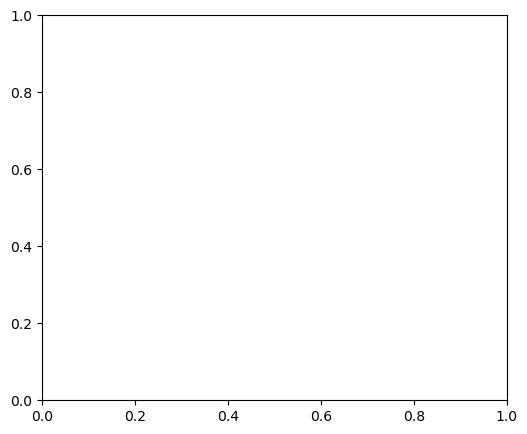

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [4]:
# %%writefile ml/shap/predict_with_shap_usage.py
import pandas as pd
import logging
import os
import json
from pathlib import Path
from typing import Any, Dict, List, Optional
from datetime import datetime
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import pickle
import logging.config
import ast

# Import configuration loader and models
from ml.config.config_loader import load_config
from ml.config.config_models import AppConfig
# Import other necessary modules
from ml.train_utils.train_utils import load_model
from ml.feature_selection.feature_importance_calculator import manage_features

# Assume these are imported in the modules that call them
from datapreprocessor import DataPreprocessor
from ml.predict.predict import predict_and_attach_predict_probs

# Import utility functions from our SHAP modules
from ml.shap.predict_with_shap_usage_utils import compute_original_metric_error, generate_feedback_and_expand
from ml.shap.shap_utils import load_dataset, setup_logging, load_configuration, initialize_logger

# Import SHAP helper classes
from ml.shap.shap_calculator import ShapCalculator
from ml.shap.shap_visualizer import ShapVisualizer
from ml.shap.feedback_generator import FeedbackGenerator

def predict_and_shap(
      config: AppConfig,
      df_input: pd.DataFrame,
      save_dir: Path,
      columns_to_add: Optional[List[str]] = None,
      generate_summary_plot: bool = True,
      generate_dependence_plots: bool = False,
      generate_force_plots: bool = False,
      force_plot_indices: Optional[List[int]] = None,
      top_n_features: int = 10,
      use_mad: bool = False,
      logger: Optional[logging.Logger] = None,
      # Optional overrides for feature file paths:
      features_file: Optional[Path] = None,
      ordinal_file: Optional[Path] = None,
      nominal_file: Optional[Path] = None,
      numericals_file: Optional[Path] = None,
      y_variable_file: Optional[Path] = None,
      model_save_dir_override: Optional[Path] = None,
      transformers_dir_override: Optional[Path] = None,
      metrics_percentile: float = 10,
      override_model_name: Optional[str] = None  # <<-- NEW parameter to override the best model name
) -> Dict[str, Any]:
    """
    Perform prediction and SHAP analysis on the input DataFrame.
    (Docstring unchanged for brevity.)
    """
    results = {}
    # Use dot‑notation to access configuration values.
    data_dir = Path(config.paths.data_dir).resolve()
    model_save_dir = (Path(config.paths.model_save_base_dir).resolve() 
                      if model_save_dir_override is None 
                      else model_save_dir_override.resolve())
    transformers_dir = (Path(config.paths.transformers_save_base_dir).resolve() 
                        if transformers_dir_override is None 
                        else transformers_dir_override.resolve())
    # Use configuration for feature paths.
    features_file = Path(config.paths.features_metadata_file) if features_file is None else features_file
    ordinal_file = Path(config.paths.ordinal_categoricals_file) if ordinal_file is None else ordinal_file
    nominal_file = Path(config.paths.nominal_categoricals_file) if nominal_file is None else nominal_file
    numericals_file = Path(config.paths.numericals_file) if numericals_file is None else numericals_file
    y_variable_file = Path(config.paths.y_variable_file) if y_variable_file is None else y_variable_file

    # Load tuning results and select the best model.
    tuning_results_path = model_save_dir / "tuning_results.json"
    print(f"tuning_results_path: {tuning_results_path}")
    if not tuning_results_path.exists():
        raise FileNotFoundError(f"Tuning results not found at '{tuning_results_path}'.")
    with open(tuning_results_path, 'r') as f:
        tuning_results = json.load(f)
    best_model_info = tuning_results.get("Best Model")
    if not best_model_info:
        raise ValueError("Best model information not found in tuning results.")
    best_model_name = best_model_info.get("model_name")
    if not best_model_name:
        raise ValueError("Best model name not found in tuning results.")
    # <<-- If an override is provided, use that model name instead.
    if override_model_name:
        best_model_name = override_model_name
        if logger:
            logger.info(f"Overriding best model selection; using model: {best_model_name}")
    else:
        if logger:
            logger.info(f"Best model identified from tuning results: {best_model_name}")

    # Load the best model from the consistent save directory.
    try:
        model = load_model(best_model_name, model_save_dir)
        if logger:
            logger.info(f"Trained model loaded from '{model_save_dir}' using model name '{best_model_name}'.")
    except Exception as e:
        if logger:
            logger.error(f"Failed to load the best model '{best_model_name}': {e}")
        raise

    # Load feature lists via manage_features.
    feature_paths = {
        'features': features_file,
        'ordinal_categoricals': ordinal_file,
        'nominal_categoricals': nominal_file,
        'numericals': numericals_file,
        'y_variable': y_variable_file
    }
    try:
        feature_lists = manage_features(mode='load', paths=feature_paths)
        y_variable_list = feature_lists.get('y_variable', [])
        ordinal_categoricals = feature_lists.get('ordinal_categoricals', [])
        nominal_categoricals = feature_lists.get('nominal_categoricals', [])
        numericals = feature_lists.get('numericals', [])
        if logger:
            logger.debug(f"Loaded Feature Lists: y_variable={y_variable_list}, ordinal_categoricals={ordinal_categoricals}, nominal_categoricals={nominal_categoricals}, numericals={numericals}")
    except Exception as e:
        if logger:
            logger.warning(f"Feature lists could not be loaded: {e}")
        y_variable_list, ordinal_categoricals, nominal_categoricals, numericals = [], [], [], []

    # Initialize the SHAP helper classes.
    from ml.shap.shap_calculator import ShapCalculator  # import here if needed
    from ml.shap.feedback_generator import FeedbackGenerator
    from ml.shap.shap_visualizer import ShapVisualizer
    shap_calculator = ShapCalculator(model=model, logger=logger)
    feedback_generator = FeedbackGenerator(logger=logger)
    shap_visualizer = ShapVisualizer(logger=logger)

    # Initialize DataPreprocessor.
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        y_variable=y_variable_list,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=numericals,
        mode='predict',
        options={},
        debug=True,
        normalize_debug=False,
        normalize_graphs_output=False,
        graphs_output_dir=Path(config.paths.plots_output_dir).resolve(),
        transformers_dir=transformers_dir
    )
    
    # Preprocess the input DataFrame.
    X_preprocessed, recommendations, X_inversed = preprocessor.final_preprocessing(df_input)
    logger.info("Preprocessing completed successfully in predict mode.")

    # Reindex inverse-transformed data to match the preprocessed data.
    X_inversed = X_inversed.reindex(X_preprocessed.index)
    logger.debug(f"X_preprocessed index: {X_preprocessed.index.tolist()}")
    logger.debug(f"X_inversed index after reindexing: {X_inversed.index.tolist()}")

    # Compute predictions and attach them.
    predictions, prediction_probs, X_inversed = predict_and_attach_predict_probs(model, X_preprocessed, X_inversed)
    results['predictions'] = predictions
    results['prediction_probs'] = prediction_probs
    logger.info("Predictions generated and attached to the dataset.")

    # Compute SHAP values using our updated SHAP calculator.
    explainer, shap_values = shap_calculator.compute_shap_values(X_preprocessed, debug=config.logging.debug)
    results['shap_values'] = shap_values
    results['explainer'] = explainer
    results['X_preprocessed'] = X_preprocessed
    logger.info("SHAP values computed successfully.")
    logger.debug(f"SHAP values shape: {shap_values.shape}")
    
    # -----------------------------------------------------------
    # IMPORTANT UPDATE:
    # Instead of using X_inversed (17 features) for expected_features,
    # we use X_preprocessed (14 features) to match the SHAP computation.
    # -----------------------------------------------------------
    expected_features = X_preprocessed.columns.tolist()
    logger.debug(f"SHAP features count: {len(X_preprocessed.columns)}")
    logger.debug(f"Expected features count (from X_preprocessed): {len(expected_features)}")
    # Optionally, add an assertion during development:
    # assert set(X_preprocessed.columns) == set(expected_features), "Feature mismatch!"
    
    # Generate and expand feedback.
    X_inversed = generate_feedback_and_expand(
        X_inversed=X_inversed,
        shap_values=shap_values,
        logger=logger,
        feedback_generator=feedback_generator,
        metrics_percentile=metrics_percentile,
        expected_features=expected_features,  # now using the correct features list
        reference_index=X_preprocessed.index
    )
    results['final_dataset'] = X_inversed
    logger.info("Feedback generation and metric threshold application completed.")

    # Generate plots if required.
    if generate_summary_plot:
        shap_summary_path = save_dir / "shap_summary.png"
        try:
            shap_visualizer.plot_summary(shap_values, X_preprocessed, shap_summary_path, debug=config.logging.debug)
            results['shap_summary_plot'] = str(shap_summary_path)
            logger.info(f"SHAP summary plot saved at {shap_summary_path}.")
        except Exception as e:
            logger.error(f"Failed to generate SHAP summary plot: {e}")

    if generate_dependence_plots:
        try:
            recommendations_dict = feedback_generator.generate_global_recommendations(
                shap_values=shap_values,
                X_original=X_preprocessed,
                top_n=top_n_features,
                use_mad=use_mad,
                debug=config.logging.debug
            )
            results['recommendations'] = recommendations_dict
            shap_dependence_dir = save_dir / "shap_dependence_plots"
            shap_dependence_dir.mkdir(parents=True, exist_ok=True)
            for feature in recommendations_dict.keys():
                dep_path = shap_dependence_dir / f"shap_dependence_{feature}.png"
                shap_visualizer.plot_dependence(shap_values, feature, X_preprocessed, dep_path, interaction_index=None, debug=config.logging.debug)
            logger.info(f"SHAP dependence plots saved at {shap_dependence_dir}.")
        except Exception as e:
            logger.error(f"Failed to generate SHAP dependence plots: {e}")

    if generate_force_plots and force_plot_indices:
        try:
            force_plots_dir = save_dir / "shap_force_plots"
            force_plots_dir.mkdir(parents=True, exist_ok=True)
            for idx in force_plot_indices:
                if idx < 0 or idx >= X_preprocessed.shape[0]:
                    logger.warning(f"Index {idx} is out of bounds. Skipping.")
                    continue
                force_path = force_plots_dir / f"shap_force_plot_{idx}.html"
                shap_visualizer.plot_force(explainer, shap_values, X_preprocessed, idx, force_path, debug=config.logging.debug)
            logger.info(f"SHAP force plots saved at {force_plots_dir}.")
        except Exception as e:
            logger.error(f"Failed to generate SHAP force plots: {e}")

    # Optionally add extra columns from the input DataFrame.
    if columns_to_add:
        try:
            logger.info(f"Adding columns from df_input to final_df: {columns_to_add}")
            for column in columns_to_add:
                if column not in df_input.columns:
                    logger.warning(f"Column '{column}' not found in input DataFrame.")
                    continue
                if len(df_input) != len(X_inversed):
                    logger.error("Length mismatch between df_input and X_inversed.")
                    raise ValueError("Length mismatch between df_input and X_inversed.")
                X_inversed[column] = df_input[column].values
            logger.info(f"Columns added successfully: {columns_to_add}")
        except Exception as e:
            logger.error(f"Failed to add columns to final_df: {e}")
            raise

    # Save the final dataset.
    try:
        final_dataset_path = save_dir / "final_predictions_with_shap.csv"
        logger.info(f"Saving final dataset with SHAP annotations to {final_dataset_path}.")
        X_inversed.to_csv(final_dataset_path, index=True)
        results['final_dataset'] = str(final_dataset_path)
        logger.info("Final dataset and global recommendations saved.")
    except Exception as e:
        logger.error(f"Failed to save outputs: {e}")
        raise

    logger.info("Predict+SHAP pipeline completed successfully.")
    return results


def convert_np_types(obj):
    if isinstance(obj, dict):
        return {k: convert_np_types(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_np_types(i) for i in obj]
    elif isinstance(obj, np.generic):
        return obj.item()
    else:
        return obj


if __name__ == "__main__":
    # Main testing block for trying multiple models.
    config_path = Path('../../data/model/preprocessor_config/preprocessor_config.yaml')
    try:
        config: AppConfig = load_config(config_path)
        print(f"Configuration loaded successfully from {config_path}.")
    except Exception as e:
        print(f"❌ Failed to load configuration: {e}")
        exit(1)

    data_dir = Path(config.paths.data_dir).resolve()
    raw_data_path = data_dir / config.paths.raw_data
    predictions_output_path = Path(config.paths.predictions_output_dir).resolve() / "shap_results"

    log_dir = Path(config.paths.log_dir).resolve()
    log_file = Path(config.paths.log_file).resolve()

    try:
        logger = setup_logging(config, log_file)
        logger.info("Starting prediction module (unified predict_and_shap).")
        logger.debug(f"Paths: {config.paths}")
    except Exception as e:
        print(f"❌ Failed to set up logging: {e}")
        exit(1)

    try:
        df_predict = load_dataset(raw_data_path)
        print("Columns in input data:", df_predict.columns.tolist())
        logger.info(f"Prediction input data loaded from {raw_data_path}.")
    except Exception as e:
        logger.error(f"Failed to load input data: {e}")
        exit(1)

    # List of model names to test.
    test_model_names = ["XGBoost", "Random Forest", "CatBoost"]

    for model_name in test_model_names:
        print(f"\n--- Running pipeline for model: {model_name} ---")
        # Create a separate output subdirectory for each model.
        model_output_dir = predictions_output_path / model_name.replace(" ", "_")
        model_output_dir.mkdir(parents=True, exist_ok=True)

        try:
            results = predict_and_shap(
                config=config,
                df_input=df_predict,
                save_dir=model_output_dir,
                columns_to_add=['trial_id'],
                generate_summary_plot=True,
                generate_dependence_plots=True,
                generate_force_plots=True,
                force_plot_indices=[0],
                top_n_features=10,
                use_mad=False,
                logger=logger,
                features_file=(Path(config.paths.data_dir) / config.paths.features_metadata_file).resolve(),
                ordinal_file=Path(f'{Path("../../data") / "preprocessor" / "features_info"}/ordinal_categoricals.pkl'),
                nominal_file=Path(f'{Path("../../data") / "preprocessor" / "features_info"}/nominal_categoricals.pkl'),
                numericals_file=Path(f'{Path("../../data") / "preprocessor" / "features_info"}/numericals.pkl'),
                y_variable_file=Path(f'{Path("../../data") / "preprocessor" / "features_info"}/y_variable.pkl'),
                model_save_dir_override=Path(config.paths.model_save_base_dir),
                transformers_dir_override=Path(config.paths.transformers_save_base_dir),
                metrics_percentile=10,
                override_model_name=model_name  # <<-- override to use the current model in the loop
            )
            logger.info(f"Unified predict_and_shap function executed successfully for model {model_name}.")
        except Exception as e:
            logger.error(f"Unified predict_and_shap function failed for model {model_name}: {e}")
            continue

        try:
            print(f"\nFinal Predictions with SHAP annotations for model {model_name} (preview):")
            final_df = pd.read_csv(results['final_dataset'], index_col=0)
            print(final_df.head())
            logger.debug(f"Final DataFrame columns for {model_name}: {final_df.columns.tolist()}")
            trial_index = 0
            if trial_index < final_df.shape[0]:
                shap_columns = [col for col in final_df.columns if col.startswith('shap_')]
                logger.debug(f"'shap_' columns for feedback in {model_name}: {shap_columns}")
                if not shap_columns:
                    logger.error("No 'shap_' columns found in the final DataFrame.")
                    print("No feedback columns found in the final DataFrame.")
                else:
                    print(f"\nFeedback for trial at index {trial_index} for model {model_name}:")
                    feedback = final_df.iloc[trial_index][shap_columns].to_dict()
                    for metric, suggestion in feedback.items():
                        print(f"  - {metric}: {suggestion}")
            else:
                print(f"No feedback found for trial at index {trial_index} in model {model_name}.")
        except Exception as e:
            logger.error(f"Failed to display outputs for model {model_name}: {e}")

    print("All tests completed.")
    print("ATTENTION HERE=", config.paths.model_save_base_dir)
    print("Current working directory:", os.getcwd())
